In [21]:
import os
import gc
import math

# numpy
import numpy as np
import numpy.ma as ma

from jax import vmap, grad, jit, random
from jax.config import config
# from jax.experimental import optimizers
import jax.numpy as jnp
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

config.update("jax_enable_x64", True)

from skimage.restoration import estimate_sigma
from skimage.transform import resize

### CRPS
import properscoring as ps

### SSIM and PSNR
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter
plt.style.use('default')

from matplotlib.gridspec import GridSpec
from matplotlib import colors
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# netCDF
import netCDF4 as nc

from tqdm.notebook import tqdm
from tqdm.notebook import trange

from scipy.stats import norm

import pickle

In [2]:
nfit = 789
nval = 9
pred_int = 70
tas = np.load('../data/saved/t2m_obs.npy', mmap_mode = 'r')[nfit:(nfit + pred_int),]
# tas = np.array(tas)

pr = np.load('../data/saved/pr_obs.npz.npy', mmap_mode = 'r')[nfit:(nfit + pred_int),]
# pr = np.array(pr)

In [3]:
nlat = tas.shape[1]
nlon = tas.shape[2]
nlat, nlon

(721, 1440)

In [4]:
pred_int = 70
scale = np.cos(np.linspace(math.pi/2, -math.pi/2, nlat))
scale /= np.mean(scale)
scale = scale.reshape((1, -1, 1))

In [5]:
### load predictions
tas_nngp = np.load('./tas_predictions/nngp_pred.npy', mmap_mode = 'r')[0:pred_int]
tas_lm = np.load('./tas_predictions/lm_pred.npy', mmap_mode = 'r')[nval:(nval+pred_int)]
tas_ens = np.load('./tas_predictions/ens_pred.npy', mmap_mode = 'r')[nval:(nval+pred_int)]

pr_nngp = np.load('./pr_predictions/nngp_pred.npy', mmap_mode = 'r')[0:pred_int]
pr_lm = np.load('./pr_predictions/lm_pred.npy', mmap_mode = 'r')[nval:(nval+pred_int)]
pr_ens = np.load('./pr_predictions/ens_pred.npy', mmap_mode = 'r')[nval:(nval+pred_int)]


### load UQ
tas_nngpvar = np.load('./tas_predictions/nngp_predvar.npy', mmap_mode = 'r')[0:pred_int]
tas_lmvar = np.load('./tas_predictions/lm_predvar.npy', mmap_mode = 'r')
tas_ensvar = np.load('./tas_predictions/ens_predvar.npy', mmap_mode = 'r')[nval:(nval+pred_int)]

pr_nngpvar = np.load('./pr_predictions/nngp_predvar.npy', mmap_mode = 'r')[0:pred_int]
pr_lmvar = np.load('./pr_predictions/lm_predvar.npy', mmap_mode = 'r')
pr_ensvar = np.load('./pr_predictions/ens_predvar.npy', mmap_mode = 'r')[nval:(nval+pred_int)]


In [7]:
### mse
tas_mse = [np.mean((tas_nngp - tas)**2 * scale, axis = (1, 2)),
              np.mean((tas_lm - tas)**2 * scale, axis = (1, 2)),
              np.mean((tas_ens - tas)**2 * scale, axis = (1, 2))]

### ssim
tas_ssim = [np.array([ssim(tas[i].astype('float32'), tas_nngp[i].astype('float32')) for i in trange(pred_int)]),
               np.array([ssim(tas[i].astype('float32'), tas_lm[i].astype('float32')) for i in trange(pred_int)]),
               np.array([ssim(tas[i].astype('float32'), tas_ens[i].astype('float32')) for i in trange(pred_int)])]

### mse
pr_mse = [np.mean((pr_nngp - pr)**2 * scale, axis = (1, 2)),
              np.mean((pr_lm - pr)**2 * scale, axis = (1, 2)),
              np.mean((pr_ens - pr)**2 * scale, axis = (1, 2))]

### ssim
pr_ssim = [np.array([ssim(pr[i].astype('float32'), pr_nngp[i].astype('float32')) for i in trange(pred_int)]),
               np.array([ssim(pr[i].astype('float32'), pr_lm[i].astype('float32')) for i in trange(pred_int)]),
               np.array([ssim(pr[i].astype('float32'), pr_ens[i].astype('float32')) for i in trange(pred_int)])]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

In [8]:
def empirical_coverage(y, yhat, ysig):
    lb = yhat - 1.96 * ysig
    ub = yhat + 1.96 * ysig
    oob = (y > ub) + (y < lb)
    oob = oob * scale
    cover = 1-np.mean(oob, axis = (1, 2))
    return cover

In [9]:
### crps
tas_crps = [np.mean(ps.crps_gaussian(tas, tas_nngp, tas_nngpvar[:,None,None]), axis = (1, 2)),
            np.mean(ps.crps_gaussian(tas, tas_lm, tas_lmvar), axis = (1, 2)),
            np.mean(ps.crps_gaussian(tas, tas_ens, tas_ensvar), axis = (1, 2))]

### cover
tas_cover = [empirical_coverage(tas, tas_nngp, tas_nngpvar[:,None,None]),
             empirical_coverage(tas, tas_lm, tas_lmvar),
             empirical_coverage(tas, tas_ens, tas_ensvar)]

### crps
pr_crps = [np.mean(ps.crps_gaussian(pr, pr_nngp, pr_nngpvar[:,None,None]) * scale, axis = (1, 2)),
            np.mean(ps.crps_gaussian(pr, pr_lm, pr_lmvar) * scale, axis = (1, 2)),
            np.mean(ps.crps_gaussian(pr, pr_ens, pr_ensvar) * scale, axis = (1, 2))]

### cover
pr_cover = [empirical_coverage(pr, pr_nngp, pr_nngpvar[:,None,None]),
             empirical_coverage(pr, pr_lm, pr_lmvar),
             empirical_coverage(pr, pr_ens, pr_ensvar)]


In [44]:
from jax.scipy.special import ndtr as ndtr

def normal_cdf(x, m, s):
    x = (x - m) / s
    return np.array(ndtr(x))

def pit_image(y, yhat, ysig):
    score = normal_cdf(y, yhat, ysig)
    emp_hist = np.histogram(score.flatten(), density=True)[0]
    return np.sqrt(np.mean((emp_hist - 1)**2))

In [45]:
pit_nngp = [pit_image(tas[i], tas_nngp[i], tas_nngpvar[i]) for i in trange(tas.shape[0])]
pit_lm = [pit_image(tas[i], tas_lm[i], tas_lmvar[i]) for i in trange(tas.shape[0])]
pit_ens = [pit_image(tas[i], tas_ens[i], tas_ensvar[i]) for i in trange(tas.shape[0])]

tas_pit = [pit_nngp, pit_lm, pit_ens]

pit_nngp = [pit_image(pr[i], pr_nngp[i], pr_nngpvar[i]) for i in trange(pr.shape[0])]
pit_lm = [pit_image(pr[i], pr_lm[i], pr_lmvar[i]) for i in trange(pr.shape[0])]
pit_ens = [pit_image(pr[i], pr_ens[i], pr_ensvar[i]) for i in trange(pr.shape[0])]

pr_pit = [pit_nngp, pit_lm, pit_ens]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

In [46]:
tas_metrics = [tas_mse, tas_ssim, tas_crps, tas_cover, tas_pit]
pr_metrics = [pr_mse, pr_ssim, pr_crps, pr_cover, pr_pit]

In [47]:
tas_msemaps = [np.mean((tas_nngp - tas)**2, axis = 0),
              np.mean((tas_lm  - tas)**2, axis = 0),
              np.mean((tas_ens  - tas)**2, axis = 0)]

pr_msemaps = [np.mean((pr_nngp - pr)**2, axis = 0),
              np.mean((pr_lm  - pr)**2, axis = 0),
              np.mean((pr_ens  - pr)**2, axis = 0)]

In [48]:
top = cm.get_cmap('bone', 128)
bottom = cm.get_cmap('OrRd', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 100)),
#                        [1,1,1,1],
                       bottom(np.linspace(0, 1, 100))))
newcmp = ListedColormap(newcolors)

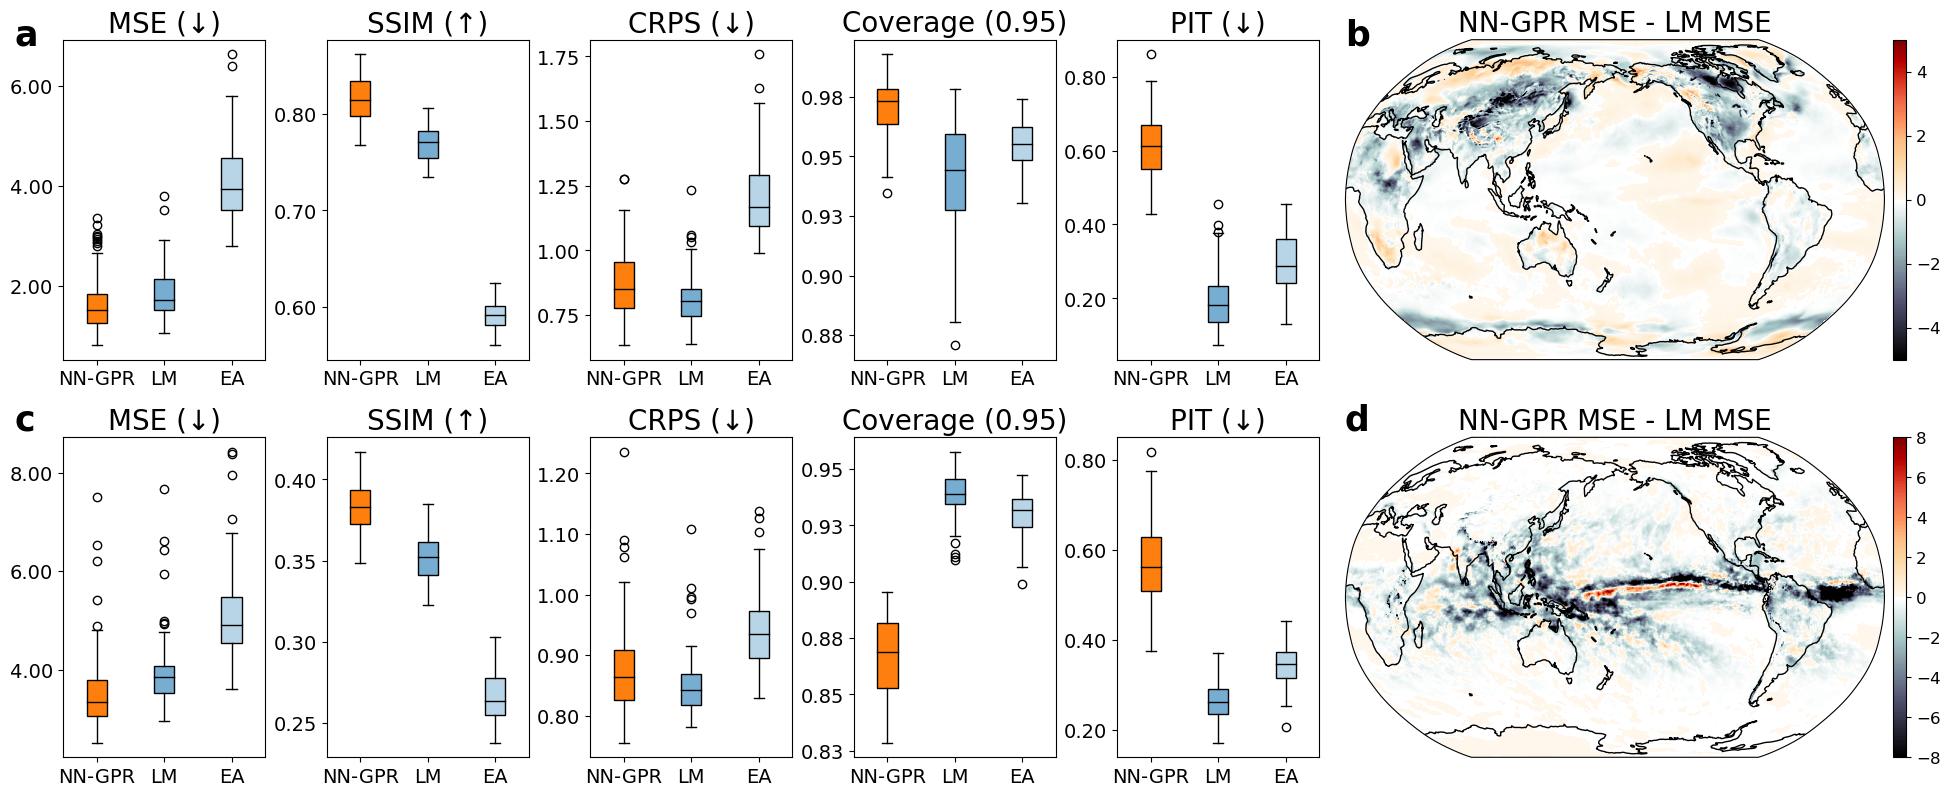

In [62]:
####### boxplots
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)


# color the plots
plt_colors = ['C1', '#1f77b499', '#1f77b450']
titles = ['MSE (\u2193)', 'SSIM (\u2191)', 'CRPS (\u2193)', 'Coverage (0.95)', 'PIT (\u2193)']
models = ['NN-GPR', 'LM', 'EA']

data_crs = ccrs.PlateCarree(central_longitude=180)
plot_crs = ccrs.Robinson(central_longitude=180)

fig = plt.figure(constrained_layout = True, figsize = (20, 8))
gs = GridSpec(2, 8, width_ratios = [0.75, 0.75, 0.75, 0.75, 0.75, 1, 1, 0.05], figure = fig)

######### TAS
ax = plt.subplot(gs[0, 0])
ax.text(0.035, 0.932, 'a', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)

for i, metric in enumerate(tas_metrics):
    ax = plt.subplot(gs[0, i])
    bp = ax.boxplot(metric, patch_artist=True, labels=models)
    ax.tick_params(axis='both', which='major', labelsize = 14)
    ax.set_title(titles[i], fontsize = 20)
    ax.locator_params(axis='y', nbins = 6)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    set_box_color(bp, 'black')
    bp['boxes'][0].set_facecolor(plt_colors[0])
    bp['boxes'][1].set_facecolor(plt_colors[1])
    bp['boxes'][2].set_facecolor(plt_colors[2])
    
    
error_diff = (tas_msemaps[0] - tas_msemaps[1]) * scale
divnorm = colors.TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)
cmap = plt.get_cmap('RdBu_r', 9) 
    
ax = plt.subplot(gs[0, (i+1):7], projection=plot_crs)
ax.text(0.7, 0.932, 'b', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)

im = ax.imshow(error_diff[0], 
               cmap = newcmp, 
               norm = divnorm,
               origin='upper', 
               transform = data_crs)
ax.coastlines()
ax.set_aspect('auto', adjustable=None)
ax.set_title('NN-GPR MSE - LM MSE', fontsize = 20)


ax = plt.subplot(gs[0, 7])
cbar = plt.colorbar(im, cax=ax)
cbar.ax.tick_params(labelsize=12)


######### PR
ax = plt.subplot(gs[1, 0])
ax.text(0.035, 0.45, 'c', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)

for i, metric in enumerate(pr_metrics):
    ax = plt.subplot(gs[1, i])
    bp = ax.boxplot(metric, patch_artist=True, labels=models)
    ax.tick_params(axis='both', which='major', labelsize = 14)
    ax.set_title(titles[i], fontsize = 20)
    ax.locator_params(axis='y', nbins = 6)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    set_box_color(bp, 'black')
    bp['boxes'][0].set_facecolor(plt_colors[0])
    bp['boxes'][1].set_facecolor(plt_colors[1])
    bp['boxes'][2].set_facecolor(plt_colors[2])
    
    
error_diff = (pr_msemaps[0] - pr_msemaps[1]) * scale
divnorm = colors.TwoSlopeNorm(vmin=-8, vcenter=0, vmax=8)
cmap = plt.get_cmap('RdBu_r', 9) 
    
ax = plt.subplot(gs[1, (i+1):7], projection=plot_crs)
ax.text(0.7, 0.45, 'd', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)
im = ax.imshow(error_diff[0],
               cmap = newcmp, 
               norm = divnorm,
               origin='upper', 
               transform = data_crs)
ax.coastlines()
ax.set_aspect('auto', adjustable=None)
ax.set_title('NN-GPR MSE - LM MSE', fontsize = 20)


ax = plt.subplot(gs[1, 7])
cbar = plt.colorbar(im, cax=ax)
cbar.ax.tick_params(labelsize=12)
plt.show()

In [32]:
tas_bias = [np.mean((tas_nngp - tas) * scale, axis = (1, 2)),
              np.mean((tas_lm - tas) * scale, axis = (1, 2)),
              np.mean((tas_ens - tas) * scale, axis = (1, 2))]

tas_std = [np.std((tas_nngp - tas) * scale, axis = (1, 2)),
              np.std((tas_lm - tas) * scale, axis = (1, 2)),
              np.std((tas_ens - tas) * scale, axis = (1, 2))]

tas_max = [np.max((tas_nngp - tas) * scale, axis = (1, 2)),
              np.max((tas_lm - tas) * scale, axis = (1, 2)),
              np.max((tas_ens - tas) * scale, axis = (1, 2))]

pr_bias = [np.mean((pr_nngp - pr) * scale, axis = (1, 2)),
              np.mean((pr_lm - pr) * scale, axis = (1, 2)),
              np.mean((tas_ens - pr) * scale, axis = (1, 2))]

pr_std = [np.std((pr_nngp - pr) * scale, axis = (1, 2)),
              np.std((pr_lm - pr) * scale, axis = (1, 2)),
              np.std((pr_ens - pr) * scale, axis = (1, 2))]

pr_max = [np.max((pr_nngp - pr) * scale, axis = (1, 2)),
              np.max((pr_lm - pr) * scale, axis = (1, 2)),
              np.max((pr_ens - pr) * scale, axis = (1, 2))]

In [34]:
print([np.round(np.mean(x), 2) for x in tas_mse])
print([np.round(np.mean(x), 2) for x in tas_ssim])
print([np.round(np.mean(x), 2) for x in tas_crps])
print([np.round(np.mean(x), 2) for x in tas_cover])
print([np.round(np.mean(x), 2) for x in tas_bias])
print([np.round(np.mean(x), 2) for x in tas_std])
print([np.round(np.mean(x), 2) for x in tas_max])

[1.69, 1.88, 4.07]
[0.82, 0.77, 0.59]
[0.88, 0.82, 1.21]
[0.97, 0.94, 0.95]
[-0.07, 0.03, 0.38]
[1.17, 1.25, 1.97]
[9.26, 10.59, 28.8]


In [35]:
print([np.round(np.mean(x), 2) for x in pr_mse])
print([np.round(np.mean(x), 2) for x in pr_ssim])
print([np.round(np.mean(x), 2) for x in pr_crps])
print([np.round(np.mean(x), 2) for x in pr_cover])
print([np.round(np.mean(x), 2) for x in pr_bias])
print([np.round(np.mean(x), 2) for x in pr_std])
print([np.round(np.mean(x), 2) for x in pr_max])

[3.56, 3.99, 5.16]
[0.38, 0.35, 0.27]
[0.88, 0.85, 0.94]
[0.87, 0.94, 0.93]
[-0.0, -0.11, 13.1]
[2.27, 2.4, 2.75]
[39.31, 42.24, 23.38]


In [ ]:
## trends comparisons

In [4]:
nfit = 789
nval = 9
pred_int = 70
nmod = 16

In [5]:
### load predictions
nngp = np.load('./tas_predictions/nngp_pred.npy', mmap_mode = 'r')
lm = np.load('./tas_predictions/lm_pred.npy', mmap_mode = 'r')[nval:]
ens = np.load('./tas_predictions/ens_pred.npy', mmap_mode = 'r')[nval:]

# nngp = np.array(nngp)
# lm = np.array(lm)
# ens = np.array(ens)

scale = np.cos(np.linspace(math.pi/2, -math.pi/2, 721))
scale /= np.mean(scale)


# aggregate by year
nngp_yr = np.array([np.mean(nngp[(i*12):((i+1)*12)] * scale[None,:,None]) for i in range(85)])
lm_yr = np.array([np.mean(lm[(i*12):((i+1)*12)] * scale[None,:,None]) for i in range(85)])
ens_yr = np.array([np.mean(ens[(i*12):((i+1)*12)] * scale[None,:,None]) for i in range(85)])

del nngp, lm, ens

xrcp = pickle.load(open('../data/saved/xrcp_tas.pkl', 'rb'))
mm_yr = []
for m in range(nmod):
    xt = xrcp[m][nval:]
    scale = np.cos(np.linspace(math.pi/2, -math.pi/2, xt.shape[1]))
    scale /= np.mean(scale)
    xt_yr = np.array([np.mean(xt[(i*12):((i+1)*12)] * scale[None,:,None]) for i in range(85)])
    
    mm_yr.append(xt_yr) 
mm_yr = np.stack(mm_yr, axis = 1)


### load observations and center
tas_mean = np.load('../data/saved/t2m_obs.npy')

scale = np.cos(np.linspace(math.pi/2, -math.pi/2, 721))
scale /= np.mean(scale)

obs = tas_mean[nfit:(nfit + pred_int)]
obs = np.array([np.mean(obs[(i*12):((i+1)*12)] * scale[None,:,None]) for i in range(6)])
tas_mean = np.mean(tas_mean * scale[None,:,None])

tas_nngp = nngp_yr - tas_mean
tas_lm = lm_yr - tas_mean
tas_ens = ens_yr - tas_mean
tas_mm = mm_yr - tas_mean
tas = obs - tas_mean

In [6]:
### load predictions
nngp = np.load('./pr_predictions/nngp_pred.npy', mmap_mode = 'r')
lm = np.load('./pr_predictions/lm_pred.npy', mmap_mode = 'r')[nval:]
ens = np.load('./pr_predictions/ens_pred.npy', mmap_mode = 'r')[nval:]

# nngp = np.array(nngp)
# lm = np.array(lm)
# ens = np.array(ens)

scale = np.cos(np.linspace(math.pi/2, -math.pi/2, 721))
scale /= np.mean(scale)


# aggregate by year
nngp_yr = np.array([np.mean(nngp[(i*12):((i+1)*12)] * scale[None,:,None]) for i in range(85)])
lm_yr = np.array([np.mean(lm[(i*12):((i+1)*12)] * scale[None,:,None]) for i in range(85)])
ens_yr = np.array([np.mean(ens[(i*12):((i+1)*12)] * scale[None,:,None]) for i in range(85)])

del nngp, lm, ens

xrcp = pickle.load(open('../data/saved/xrcp_pr.pkl', 'rb'))
mm_yr = []
for m in range(nmod):
    xt = xrcp[m][nval:]
    scale = np.cos(np.linspace(math.pi/2, -math.pi/2, xt.shape[1]))
    scale /= np.mean(scale)
    xt_yr = np.array([np.mean(xt[(i*12):((i+1)*12)] * scale[None,:,None]) for i in range(85)])
    
    mm_yr.append(xt_yr) 
mm_yr = np.stack(mm_yr, axis = 1)


### load observations and center
pr_mean = np.load('../data/saved/pr_obs.npz.npy')

scale = np.cos(np.linspace(math.pi/2, -math.pi/2, 721))
scale /= np.mean(scale)

obs = pr_mean[nfit:(nfit + pred_int)]
obs = np.array([np.mean(obs[(i*12):((i+1)*12)] * scale[None,:,None]) for i in range(6)])
pr_mean = np.mean(pr_mean * scale[None,:,None])

pr_nngp = nngp_yr - pr_mean
pr_lm = lm_yr - pr_mean
pr_ens = ens_yr - pr_mean
pr_mm = mm_yr - pr_mean
pr = obs - pr_mean

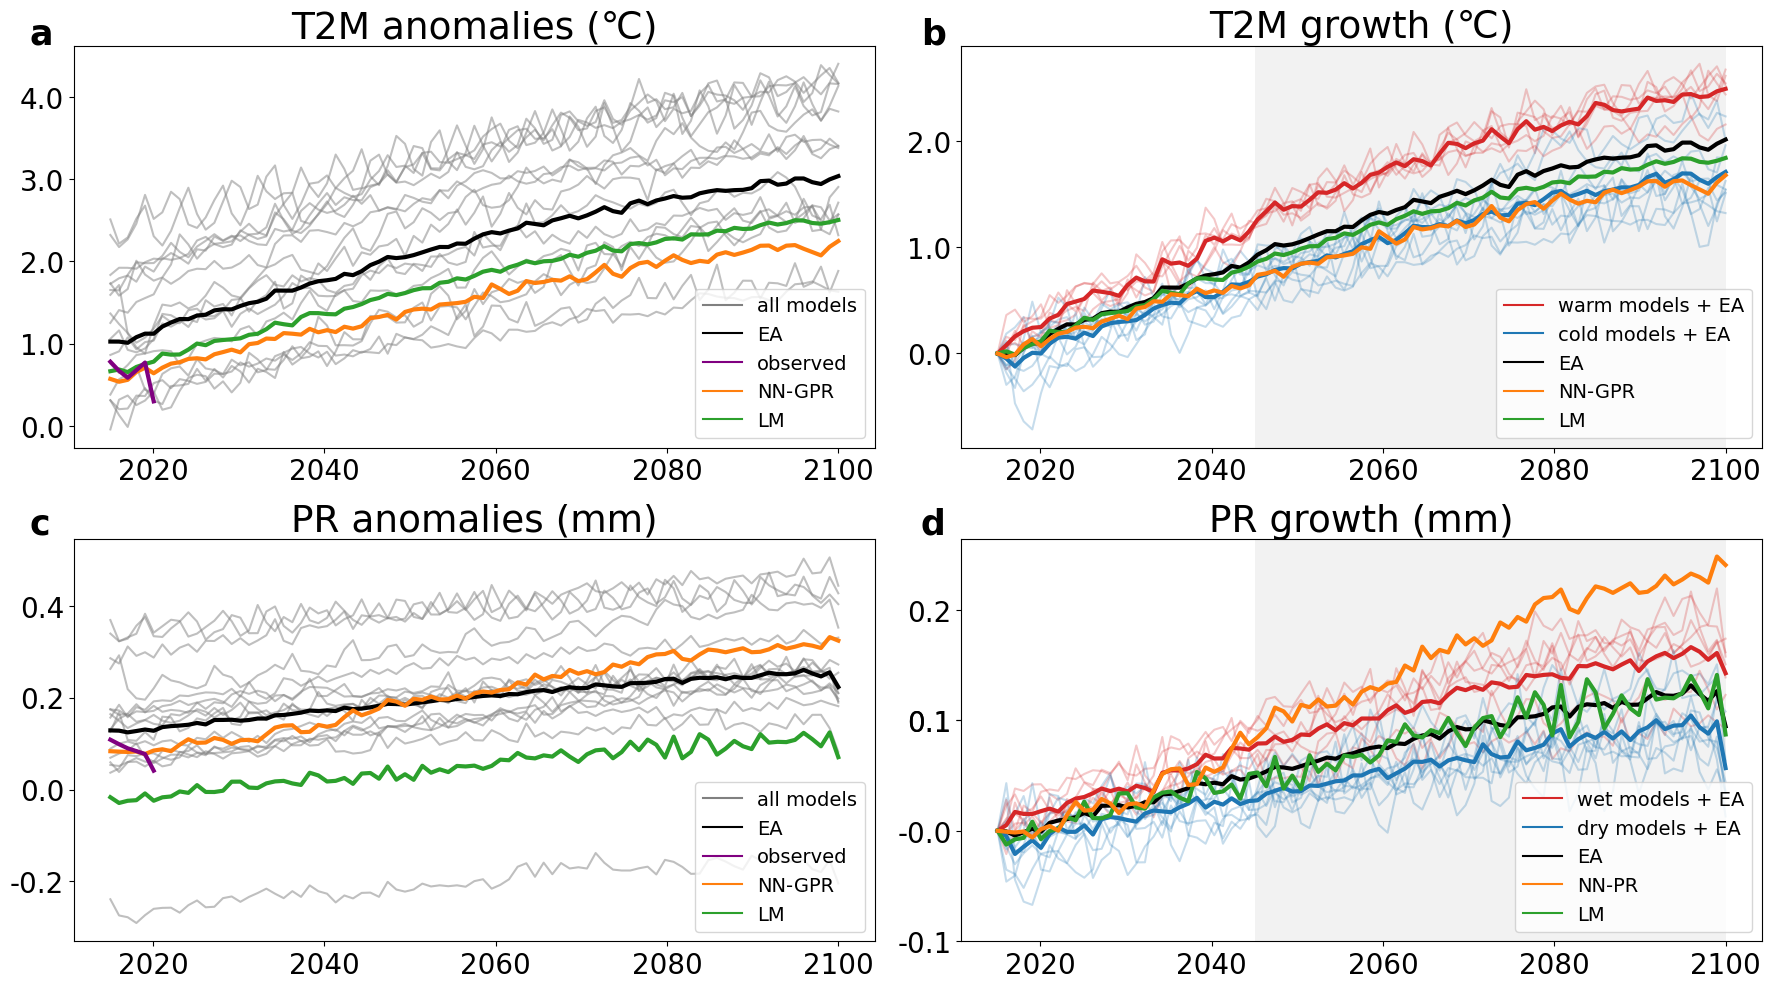

In [9]:
fig, ax = plt.subplots(2, 2, constrained_layout = True, figsize = (18, 10))
ax = ax.reshape(-1)

plt.rc('ytick', labelsize = 20)
plt.rc('xtick', labelsize = 20)


s = np.linspace(2015, 2100, 85)

#### TAS
cold_avg0 = 0
cold_avg1 = 0
warm_avg0 = 0
warm_avg1 = 0
ens_avg = 0

### plotting
n = 0
m = 0
for i in range(tas_mm.shape[1]):
    if (tas_mm[:,i] - tas_mm[0,i])[30] > 1.1:
        ax[0].plot(s, tas_mm[:,i], c = 'grey', alpha = 0.5)
        ax[1].plot(s, tas_mm[:,i] - tas_mm[0,i], c = 'C3', alpha = 0.25)
        
        m = m + 1
        warm_avg0 += tas_mm[:,i]
        warm_avg1 += tas_mm[:,i] - tas_mm[0,i]
    else:
        n = n + 1
        cold_avg0 += tas_mm[:,i]
        cold_avg1 += tas_mm[:,i] - tas_mm[0,i]
        
        ax[0].plot(s, tas_mm[:,i], c = 'grey', alpha = 0.5)
        ax[1].plot(s, tas_mm[:,i] - tas_mm[0,i], c = 'C0', alpha = 0.25)
        
ax[0].plot(s, tas_ens, c = 'black', linewidth = 3)
ax[0].plot(s, tas_lm, c = 'C2', linewidth = 3)
ax[0].plot(s, tas_nngp, c = 'C1', linewidth = 3)
ax[0].plot(s[0:6], tas, c = 'purple', linewidth = 3)
ax[0].set_title('T2M anomalies (\u2103)', fontsize = 27)

ax[1].plot(s, tas_ens - tas_ens[0], c = 'black', linewidth = 3)
ax[1].plot(s, warm_avg1/m, c = 'C3', linewidth = 3)
ax[1].plot(s, cold_avg1/n, c = 'C0', linewidth = 3)
ax[1].plot(s, tas_lm - tas_lm[0], c = 'C2', linewidth = 3)
ax[1].plot(s, tas_nngp - tas_nngp[0], c = 'C1', linewidth = 3)
ax[1].set_title('T2M growth (\u2103)', fontsize = 27)
ax[1].axvspan(2045, 2100, facecolor='grey', alpha=0.10)


### legend
ax[0].plot([],[], c='grey', label = 'all models')
ax[0].plot([],[], c='black', label = 'EA')
ax[0].plot([],[], c='purple', label = 'observed')
ax[0].plot([],[], c='C1', label = 'NN-GPR')
ax[0].plot([],[], c='C2', label = 'LM')
ax[0].legend(fontsize = 14, loc = 'lower right')

ax[1].plot([],[], c='C3', label = 'warm models + EA')
ax[1].plot([],[], c='C0', label = 'cold models + EA')
ax[1].plot([],[], c='black', label = 'EA')
ax[1].plot([],[], c='C1', label = 'NN-GPR')
ax[1].plot([],[], c='C2', label = 'LM')
ax[1].legend(fontsize = 14, loc = 'lower right')


# ### labels
custom_ticks = np.linspace(2020, 2100, 5, dtype=int)
ax[0].set_xticks(custom_ticks)
ax[0].set_xticklabels(custom_ticks)
# ax[0].set_ylabel('T2M anomalies (\u2103)', fontsize = 20)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax[1].set_xticks(custom_ticks)
ax[1].set_xticklabels(custom_ticks)
# ax[1].set_ylabel('T2M growth (\u2103)', fontsize = 20)
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax[0].text(0.035, 0.94, 'a', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)
ax[1].text(0.53, 0.94, 'b', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)


## PR
cold_avg0 = 0
cold_avg1 = 0
warm_avg0 = 0
warm_avg1 = 0
ens_avg = 0

### plotting
n = 0
m = 0
for i in range(pr_mm.shape[1]):
    if (pr_mm[:,i] - pr_mm[0,i])[30] > 0.05:
        ax[2].plot(s, pr_mm[:,i], c = 'grey', alpha = 0.5)
        ax[3].plot(s, pr_mm[:,i] - pr_mm[0,i], c = 'C3', alpha = 0.25)
        
        m = m + 1
        warm_avg0 += pr_mm[:,i]
        warm_avg1 += pr_mm[:,i] - pr_mm[0,i]
    else:
        n = n + 1
        cold_avg0 += pr_mm[:,i]
        cold_avg1 += pr_mm[:,i] - pr_mm[0,i]
        
        ax[2].plot(s, pr_mm[:,i], c = 'grey', alpha = 0.5)
        ax[3].plot(s, pr_mm[:,i] - pr_mm[0,i], c = 'C0', alpha = 0.25)
        
ax[2].plot(s, pr_ens, c = 'black', linewidth = 3)
ax[2].plot(s, pr_lm, c = 'C2', linewidth = 3)
ax[2].plot(s, pr_nngp, c = 'C1', linewidth = 3)
ax[2].plot(s[0:6], pr, c = 'purple', linewidth = 3)
ax[2].set_title('PR anomalies (mm)', fontsize = 27)

ax[3].plot(s, pr_ens - pr_ens[0], c = 'black', linewidth = 3)
ax[3].plot(s, warm_avg1/m, c = 'C3', linewidth = 3)
ax[3].plot(s, cold_avg1/n, c = 'C0', linewidth = 3)
ax[3].plot(s, pr_lm - pr_lm[0], c = 'C2', linewidth = 3)
ax[3].plot(s, pr_nngp - pr_nngp[0], c = 'C1', linewidth = 3)
ax[3].set_title('PR growth (mm)', fontsize = 27)
ax[3].axvspan(2045, 2100, facecolor='grey', alpha=0.10)


### legend
ax[2].plot([],[], c='grey', label = 'all models')
ax[2].plot([],[], c='black', label = 'EA')
ax[2].plot([],[], c='purple', label = 'observed')
ax[2].plot([],[], c='C1', label = 'NN-GPR')
ax[2].plot([],[], c='C2', label = 'LM')
ax[2].legend(fontsize = 14, loc = 'lower right')

ax[3].plot([],[], c='C3', label = 'wet models + EA')
ax[3].plot([],[], c='C0', label = 'dry models + EA')
ax[3].plot([],[], c='black', label = 'EA')
ax[3].plot([],[], c='C1', label = 'NN-PR')
ax[3].plot([],[], c='C2', label = 'LM')
ax[3].legend(fontsize = 14, loc = 'lower right')


# ### labels
custom_ticks = np.linspace(2020, 2100, 5, dtype=int)
ax[2].set_xticks(custom_ticks)
ax[2].set_xticklabels(custom_ticks)
ax[2].tick_params(axis='both', which='major', labelsize = 20)
# ax[2].set_ylabel('PR anomalies (mm/day)', fontsize = 20)
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax[3].set_xticks(custom_ticks)
ax[3].set_xticklabels(custom_ticks)
ax[2].tick_params(axis='both', which='major', labelsize = 20)
# ax[3].set_ylabel('PR growth (mm/day)', fontsize = 20)
ax[3].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


custom_ticks = np.round(np.linspace(-0.1, 0.2, 5), 1)
ax[3].set_yticks(custom_ticks)
ax[3].set_yticklabels(custom_ticks)

ax[2].text(0.035, 0.45, 'c', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)
ax[3].text(0.53, 0.45, 'd', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)
   
plt.show()

In [8]:
print(np.round(np.mean(tas_nngp - tas_ens), 2))
print(np.round(np.mean(tas_lm - tas_ens), 2))

-0.67
-0.44


In [23]:
print(np.round(np.mean(pr_nngp - pr_ens), 2))
print(np.round(np.mean(pr_lm - pr_ens), 2))

0.01
-0.15


In [30]:
print(np.round(tas_nngp[-1] - tas_nngp[0], 2))
print(np.round(tas_ens[-1] - tas_ens[0], 2))

1.68
2.01


In [ ]:
### cumulative growth anomalies

In [8]:
nfit = 789
nval = 9
pred_int = 70
nmod = 16
nlat = 721
nlon = 1440

scale = np.cos(np.linspace(math.pi/2, -math.pi/2, nlat))
scale /= np.mean(scale)

In [9]:
nngp = np.load('./tas_predictions/nngp_pred.npy', mmap_mode = 'r')
ens = np.load('./tas_predictions/lm_pred.npy', mmap_mode = 'r')[nval:]

In [10]:
### TAS
nngp = np.load('./tas_predictions/nngp_pred.npy', mmap_mode = 'r')
lm = np.load('./tas_predictions/lm_pred.npy', mmap_mode = 'r')[nval:]
ens = np.load('./tas_predictions/ens_pred.npy', mmap_mode = 'r')[nval:]

nngp_yr = np.array([np.mean(nngp[(i*12):((i+1)*12)] * scale[None,:,None], axis = 0) for i in range(85)])
lm_yr = np.array([np.mean(lm[(i*12):((i+1)*12)] * scale[None,:,None], axis = 0) for i in range(85)])
ens_yr = np.array([np.mean(ens[(i*12):((i+1)*12)] * scale[None,:,None], axis = 0) for i in range(85)])

nngp_dec = np.array([np.mean(nngp_yr[(i*20):((i+1)*20)], axis = 0) for i in range(5)])
nngp_dec = nngp_dec[0:4]
nngp_tas = nngp_dec
# nngp_tas = np.array([x - nngp_dec[0] for x in nngp_dec])

lm_dec = np.array([np.mean(lm_yr[(i*20):((i+1)*20)], axis = 0) for i in range(5)])
lm_dec = lm_dec[0:4]
lm_tas = lm_dec

ens_dec = np.array([np.mean(ens_yr[(i*20):((i+1)*20)], axis = 0) for i in range(5)])
ens_dec = ens_dec[0:4]
ens_tas = ens_dec
# ens_tas = np.array([x - ens_dec[0] for x in ens_dec])


### PR
nngp = np.load('./pr_predictions/nngp_pred.npy', mmap_mode = 'r')
lm = np.load('./pr_predictions/lm_pred.npy', mmap_mode = 'r')[nval:]
ens = np.load('./pr_predictions/ens_pred.npy', mmap_mode = 'r')[nval:]

nngp_yr = np.array([np.mean(nngp[(i*12):((i+1)*12)] * scale[None,:,None], axis = 0) for i in range(85)])
lm_yr = np.array([np.mean(lm[(i*12):((i+1)*12)] * scale[None,:,None], axis = 0) for i in range(85)])
ens_yr = np.array([np.mean(ens[(i*12):((i+1)*12)] * scale[None,:,None], axis = 0) for i in range(85)])

nngp_dec = np.array([np.mean(nngp_yr[(i*20):((i+1)*20)], axis = 0) for i in range(5)])
nngp_dec = nngp_dec[0:4]
nngp_pr = nngp_dec
# nngp_pr = np.array([x - nngp_dec[0] for x in nngp_dec])

lm_dec = np.array([np.mean(lm_yr[(i*20):((i+1)*20)], axis = 0) for i in range(5)])
lm_dec = lm_dec[0:4]
lm_pr = lm_dec
# nngp_pr = np.array([x - nngp_dec[0] for x in nngp_dec])

ens_dec = np.array([np.mean(ens_yr[(i*20):((i+1)*20)], axis = 0) for i in range(5)])
ens_dec = ens_dec[0:4]
ens_pr = ens_dec
# ens_pr = np.array([x - ens_dec[0] for x in ens_dec])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

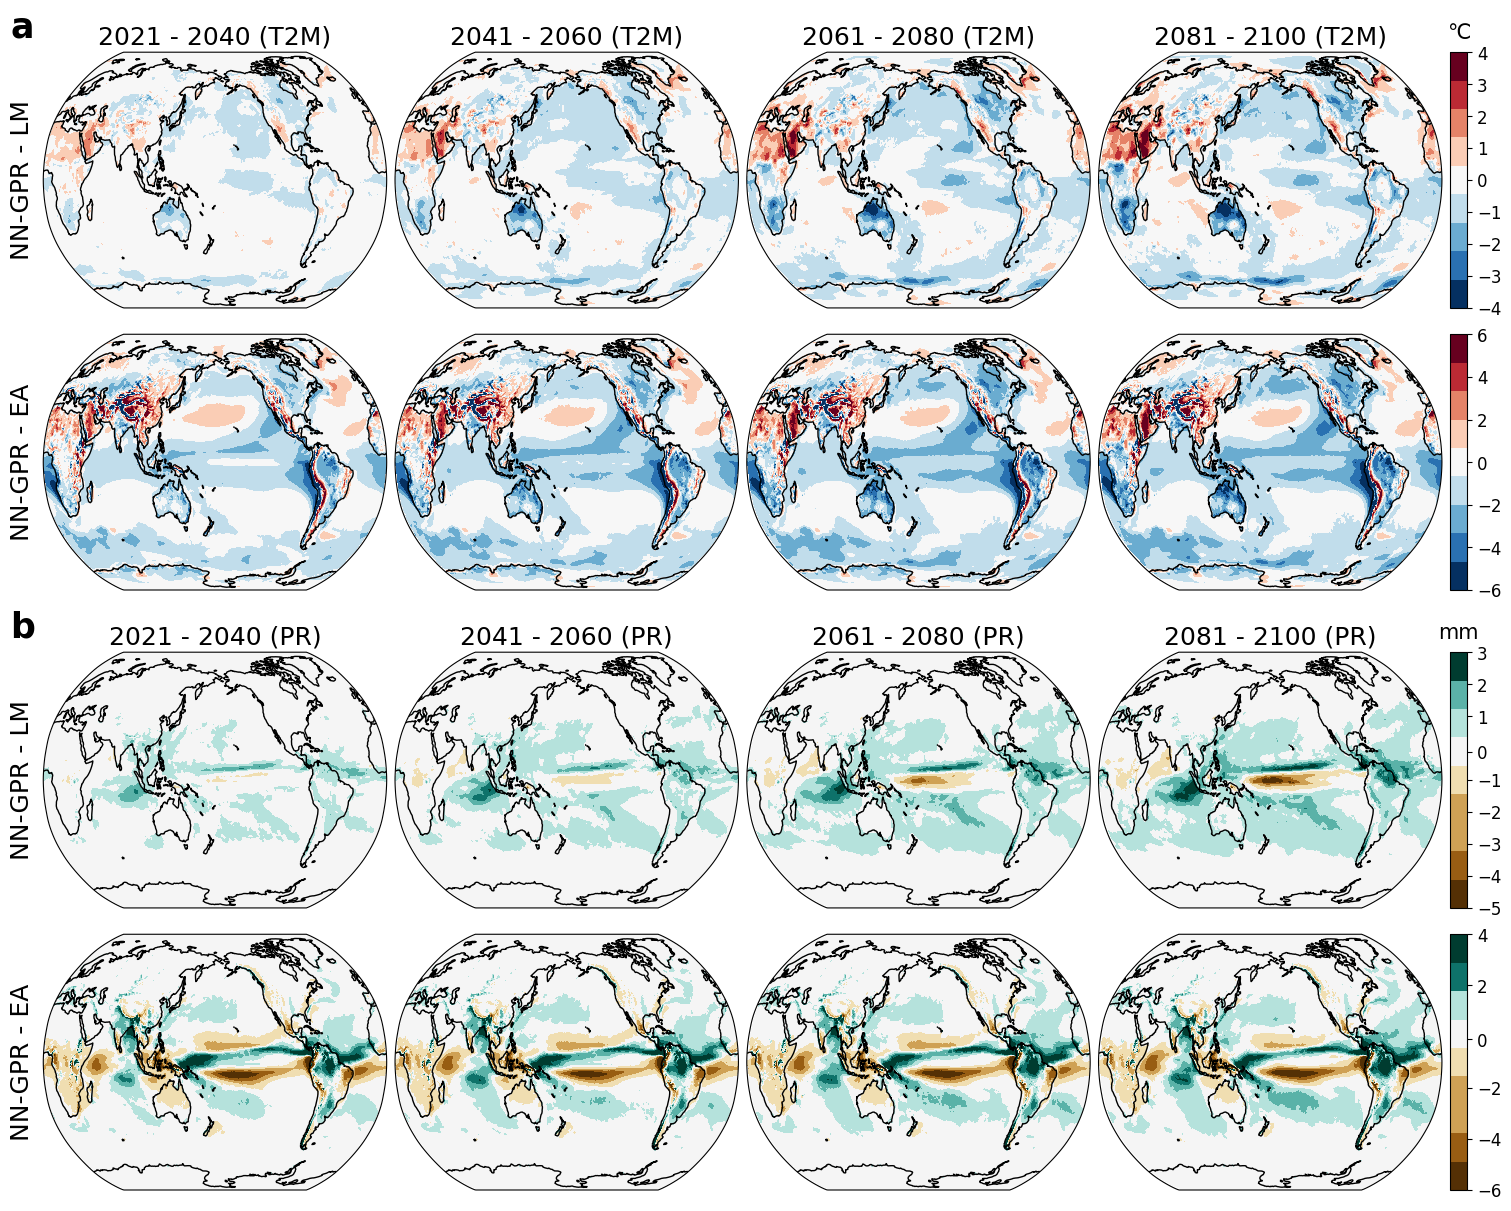

In [11]:
data_crs = ccrs.PlateCarree(central_longitude=180)
plot_crs = ccrs.Robinson(central_longitude=180)

fig = plt.figure(constrained_layout = True, figsize = (15, 12))
gs = GridSpec(4, 6, width_ratios = [0.05, 1, 1, 1, 1, 0.05], figure = fig)

times = ['2021 - 2040', '2041 - 2060', '2061 - 2080', '2081 - 2100']

### temperatures
ax = plt.subplot(gs[0, 0])
ax.axis('off')
ax.text(0.0, 0.5, 'NN-GPR - LM', rotation=90, va='center', fontsize=18)
ax.text(0.0, 1.1, 'a', va='center', fontsize=25, fontweight='bold')
divnorm = colors.TwoSlopeNorm(vmin=-4, vcenter=0, vmax=4)
cmap = plt.get_cmap('RdBu_r', 9)
for i in trange(1, 5, leave = False):
    ax = plt.subplot(gs[0, i], projection=plot_crs)
    im = ax.imshow(nngp_tas[i-1] - lm_tas[i-1], cmap = cmap, norm = divnorm, transform = data_crs)
    ax.coastlines()
    ax.set_aspect('auto', adjustable=None)
    ax.set_title(f'{times[i-1]} (T2M)', fontsize = 18)
    
ax = plt.subplot(gs[0, 5])
cbar = plt.colorbar(im, cax=ax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('\u2103', fontsize = 15, pad = 10)
    
ax = plt.subplot(gs[1, 0])
ax.axis('off')
ax.text(0.0, 0.5, 'NN-GPR - EA', rotation=90, va='center', fontsize=18)
divnorm = colors.TwoSlopeNorm(vmin=-6, vcenter=0, vmax=6)
for i in trange(1, 5, leave = False):
    ax = plt.subplot(gs[1, i], projection=plot_crs)
    im = ax.imshow(nngp_tas[i-1] - ens_tas[i-1], cmap = cmap, norm = divnorm, transform = data_crs)
    ax.coastlines()
    ax.set_aspect('auto', adjustable=None)
#     ax.set_title(f'{2020 + 10*(2*(i-1))} - {2020 + 10*(2*(i-1)+2)} (T2M)', fontsize = 15)
    
ax = plt.subplot(gs[1, 5])
cbar = plt.colorbar(im, cax=ax)
cbar.ax.tick_params(labelsize=12)
# cbar.ax.set_title('\u2103', fontsize = 15, pad = 10)



### preciptation
ax = plt.subplot(gs[2, 0])
ax.axis('off')
ax.text(0.0, 0.5, 'NN-GPR - LM', rotation=90, va='center', fontsize=18)
ax.text(0.0, 1.1, 'b', va='center', fontsize=25, fontweight='bold')
divnorm = colors.TwoSlopeNorm(vmin=-5, vcenter=0, vmax=3)
cmap = plt.get_cmap('BrBG', 9)
for i in trange(1, 5, leave = False):
    ax = plt.subplot(gs[2, i], projection=plot_crs)
    im = ax.imshow(nngp_pr[i-1] - lm_pr[i-1], cmap = cmap, norm = divnorm, transform = data_crs)
    ax.coastlines()
    ax.set_aspect('auto', adjustable=None)
    ax.set_title(f'{times[i-1]} (PR)', fontsize = 18)

ax = plt.subplot(gs[2, 5])
cbar = plt.colorbar(im, cax=ax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('mm', fontsize = 15, pad = 10)
    
ax = plt.subplot(gs[3, 0])
ax.axis('off')
ax.text(0.0, 0.5, 'NN-GPR - EA', rotation=90, va='center', fontsize=18)
divnorm = colors.TwoSlopeNorm(vmin=-6, vcenter=0, vmax=4)
for i in trange(1, 5, leave = False):
    ax = plt.subplot(gs[3, i], projection=plot_crs)
    im = ax.imshow(nngp_pr[i-1] - ens_pr[i-1], cmap = cmap, norm = divnorm, transform = data_crs)
    ax.coastlines()
    ax.set_aspect('auto', adjustable=None)
#     ax.set_title(f'{2020 + 10*(2*(i-1))} - {2020 + 10*(2*(i-1)+2)} (PR)', fontsize = 15)

ax = plt.subplot(gs[3, 5])
cbar = plt.colorbar(im, cax=ax)
cbar.ax.tick_params(labelsize=12)
# cbar.ax.set_title('mm/day', fontsize = 15, pad = 10)

plt.show()

In [ ]:
### TAS
nngp = np.load('./tas_predictions/nngp_pred.npy', mmap_mode = 'r')
# ens = np.load('./tas_predictions/lm_pred.npy', mmap_mode = 'r')[nval:]
ens = np.load('./tas_predictions/ens_pred.npy', mmap_mode = 'r')[nval:]

nngp_yr = np.array([np.mean(nngp[(i*12):((i+1)*12)] * scale[None,:,None], axis = 0) for i in range(85)])
ens_yr = np.array([np.mean(ens[(i*12):((i+1)*12)] * scale[None,:,None], axis = 0) for i in range(85)])

nngp_dec = np.array([np.mean(nngp_yr[(i*20):((i+1)*20)], axis = 0) for i in range(5)])
nngp_dec = nngp_dec[0:4]
nngp_tas = nngp_dec
# nngp_tas = np.array([x - nngp_dec[0] for x in nngp_dec])

ens_dec = np.array([np.mean(ens_yr[(i*20):((i+1)*20)], axis = 0) for i in range(5)])
ens_dec = ens_dec[0:4]
ens_tas = ens_dec
# ens_tas = np.array([x - ens_dec[0] for x in ens_dec])


### PR
nngp = np.load('./pr_predictions/nngp_pred.npy', mmap_mode = 'r')
# ens = np.load('./pr_predictions/lm_pred.npy', mmap_mode = 'r')[nval:]
ens = np.load('./pr_predictions/ens_pred.npy', mmap_mode = 'r')[nval:]

nngp_yr = np.array([np.mean(nngp[(i*12):((i+1)*12)] * scale[None,:,None], axis = 0) for i in range(85)])
ens_yr = np.array([np.mean(ens[(i*12):((i+1)*12)] * scale[None,:,None], axis = 0) for i in range(85)])

nngp_dec = np.array([np.mean(nngp_yr[(i*20):((i+1)*20)], axis = 0) for i in range(5)])
nngp_dec = nngp_dec[0:4]
nngp_pr = nngp_dec
# nngp_pr = np.array([x - nngp_dec[0] for x in nngp_dec])

ens_dec = np.array([np.mean(ens_yr[(i*20):((i+1)*20)], axis = 0) for i in range(5)])
ens_dec = ens_dec[0:4]
ens_pr = ens_dec
# ens_pr = np.array([x - ens_dec[0] for x in ens_dec])

  0%|          | 0/4 [00:00<?, ?it/s]

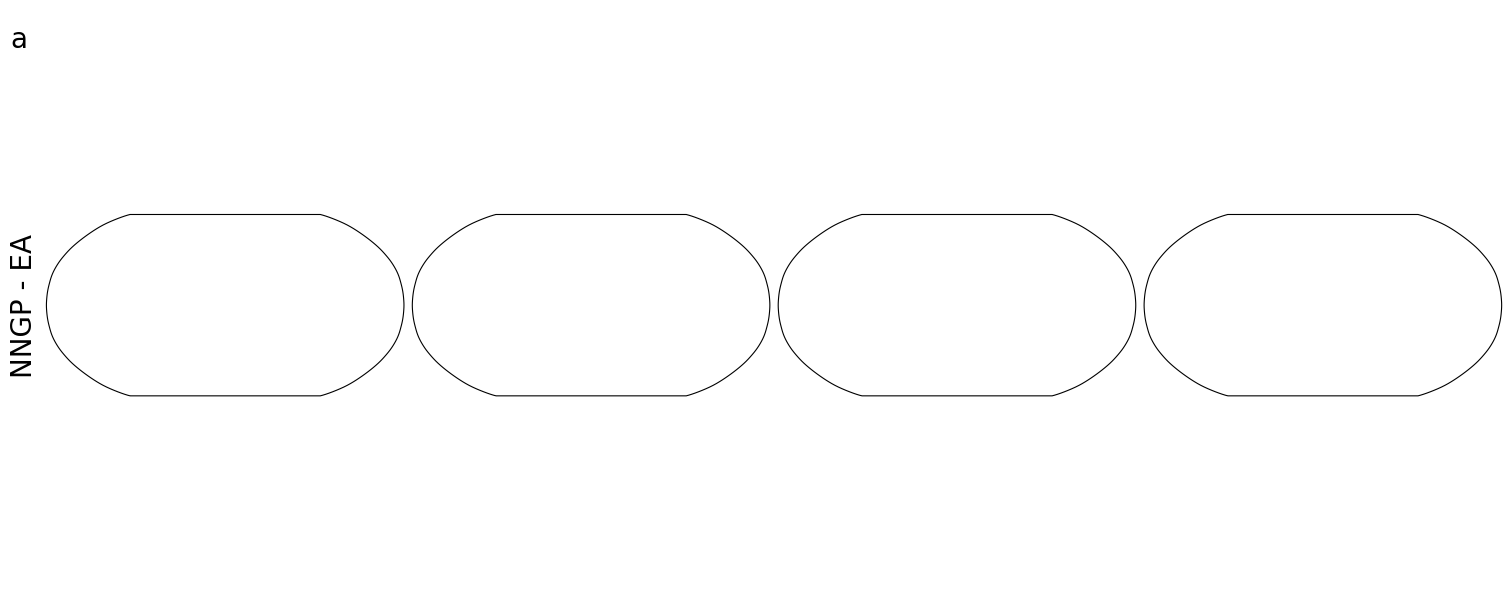

In [76]:
data_crs = ccrs.PlateCarree(central_longitude=180)
plot_crs = ccrs.Robinson(central_longitude=180)

fig = plt.figure(constrained_layout = True, figsize = (15, 6))
gs = GridSpec(1, 5, width_ratios = [0.05, 1, 1, 1, 1], figure = fig)

ax = plt.subplot(gs[0])
ax.axis('off')
ax.text(0.0, 0.5, 'NNGP - EA', rotation=90, va='center', fontsize=20)
ax.text(0.0, 0.95, 'a', va='center', fontsize=20)

for i in trange(1, 5, leave = False):
    ax = plt.subplot(gs[i], projection = plot_crs)
    if i == 0:
        ax.set_ylabel('NNGP - EA', fontsize = 32)
plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

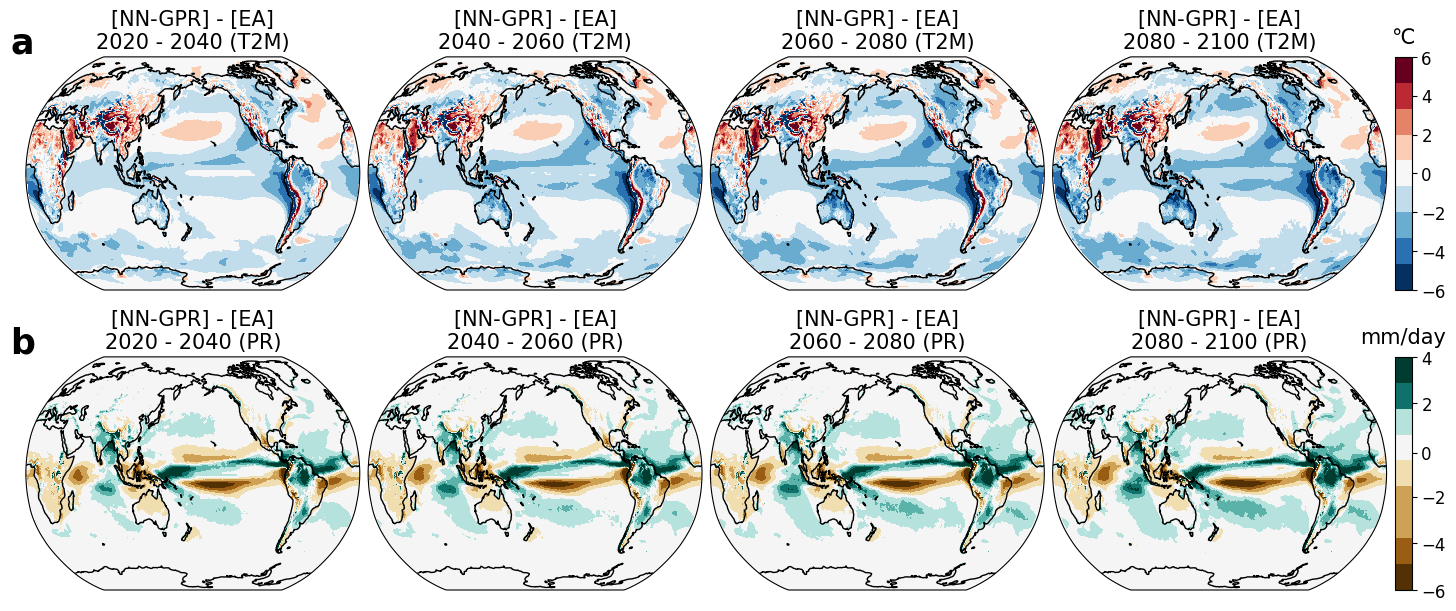

In [22]:
data_crs = ccrs.PlateCarree(central_longitude=180)
plot_crs = ccrs.Robinson(central_longitude=180)

fig = plt.figure(constrained_layout = True, figsize = (15, 6))
gs = GridSpec(2, 5, width_ratios = [1, 1, 1, 1, 0.05], figure = fig)

# ax = plt.subplot(gs[0, 0])
# ax.text(0.035, 0.45, 'a', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)

divnorm = colors.TwoSlopeNorm(vmin=-6, vcenter=0, vmax=6)
cmap = plt.get_cmap('RdBu_r', 9)
for i in trange(4, leave = False):
    ax = plt.subplot(gs[i], projection=plot_crs)
    im = ax.imshow(nngp_tas[i] - ens_tas[i], cmap = cmap, norm = divnorm, transform = data_crs)
    ax.coastlines()
    ax.set_aspect('auto', adjustable=None)
    ax.set_title(f'[NN-GPR] - [EA]\n{2020 + 10*(2*i)} - {2020 + 10*(2*i+2)} (T2M)', fontsize = 15)
    
    if i == 0:
        ax.text(0.04, 0.92, 'a', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)
    
ax = plt.subplot(gs[0, 4])
cbar = plt.colorbar(im, cax=ax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('\u2103', fontsize = 15, pad = 10)
    
divnorm = colors.TwoSlopeNorm(vmin=-6, vcenter=0, vmax=4)
cmap = plt.get_cmap('BrBG', 9)
for j in trange(4, leave = False):
    ax = plt.subplot(gs[2 + i + j], projection=plot_crs)
    im = ax.imshow(nngp_pr[j] - ens_pr[j], cmap = cmap, norm = divnorm, transform = data_crs)
    ax.coastlines()
    ax.set_aspect('auto', adjustable=None)
    ax.set_title(f'[NN-GPR] - [EA]\n{2020 + 10*(2*j)} - {2020 + 10*(2*j+2)} (PR)', fontsize = 15)
    
    if j == 0:
        ax.text(0.04, 0.42, 'b', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)
    
ax = plt.subplot(gs[1, 4])
cbar = plt.colorbar(im, cax=ax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('mm/day', fontsize = 15, pad = 10)

# ax = plt.subplot(gs[1, 0])
# ax.text(0.04, 0.45, 'c', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)

plt.show()

In [ ]:
### absolute growth, not that helpful

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

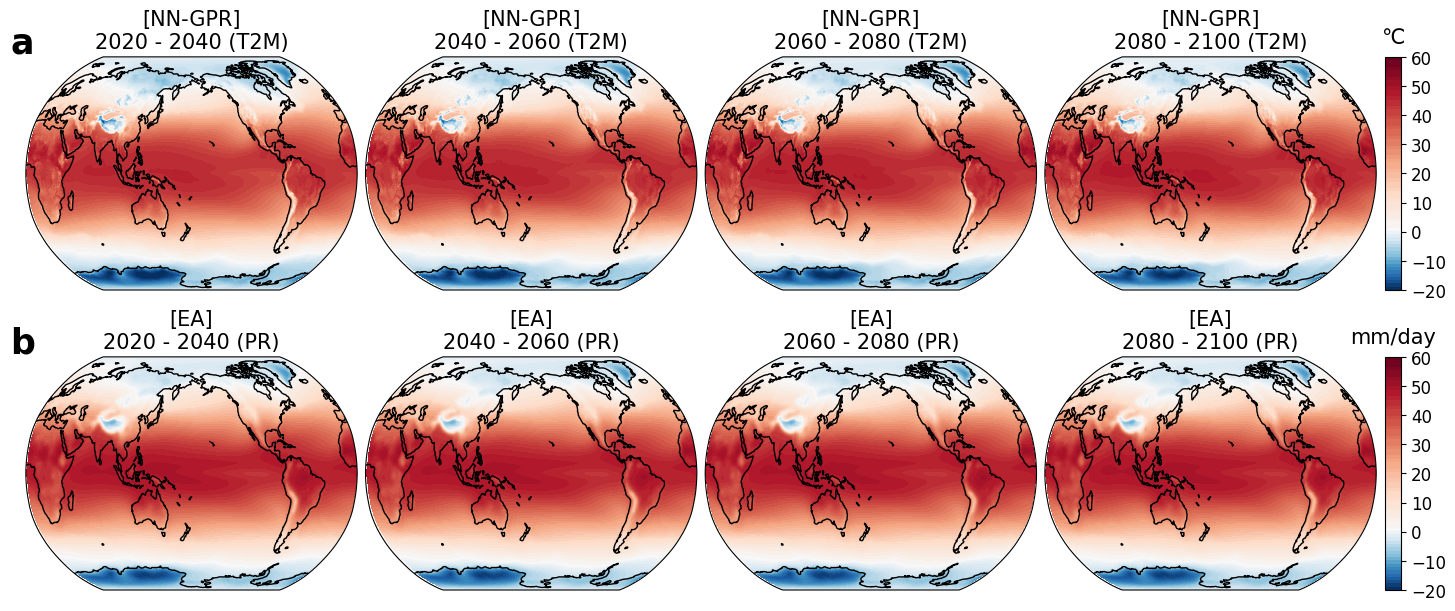

In [25]:
data_crs = ccrs.PlateCarree(central_longitude=180)
plot_crs = ccrs.Robinson(central_longitude=180)

fig = plt.figure(constrained_layout = True, figsize = (15, 6))
gs = GridSpec(2, 5, width_ratios = [1, 1, 1, 1, 0.05], figure = fig)

# ax = plt.subplot(gs[0, 0])
# ax.text(0.035, 0.45, 'a', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)

divnorm = colors.TwoSlopeNorm(vmin=-20, vcenter=1, vmax=60)
cmap = plt.get_cmap('RdBu_r', 71)
for i in trange(4, leave = False):
    ax = plt.subplot(gs[i], projection=plot_crs)
    im = ax.imshow(nngp_tas[i], cmap = cmap, norm = divnorm, transform = data_crs)
    ax.coastlines()
    ax.set_aspect('auto', adjustable=None)
    ax.set_title(f'[NN-GPR]\n{2020 + 10*(2*i)} - {2020 + 10*(2*i+2)} (T2M)', fontsize = 15)
    
    if i == 0:
        ax.text(0.04, 0.92, 'a', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)
    
ax = plt.subplot(gs[0, 4])
cbar = plt.colorbar(im, cax=ax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('\u2103', fontsize = 15, pad = 10)
    
# divnorm = colors.TwoSlopeNorm(vmin=-6, vcenter=0, vmax=4)
# cmap = plt.get_cmap('BrBG', 31)
for j in trange(4, leave = False):
    ax = plt.subplot(gs[2 + i + j], projection=plot_crs)
    im = ax.imshow(ens_tas[i], cmap = cmap, norm = divnorm, transform = data_crs)
    ax.coastlines()
    ax.set_aspect('auto', adjustable=None)
    ax.set_title(f'[EA]\n{2020 + 10*(2*j)} - {2020 + 10*(2*j+2)} (PR)', fontsize = 15)
    
    if j == 0:
        ax.text(0.04, 0.42, 'b', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)
    
ax = plt.subplot(gs[1, 4])
cbar = plt.colorbar(im, cax=ax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('mm/day', fontsize = 15, pad = 10)

# ax = plt.subplot(gs[1, 0])
# ax.text(0.04, 0.45, 'c', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)

plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

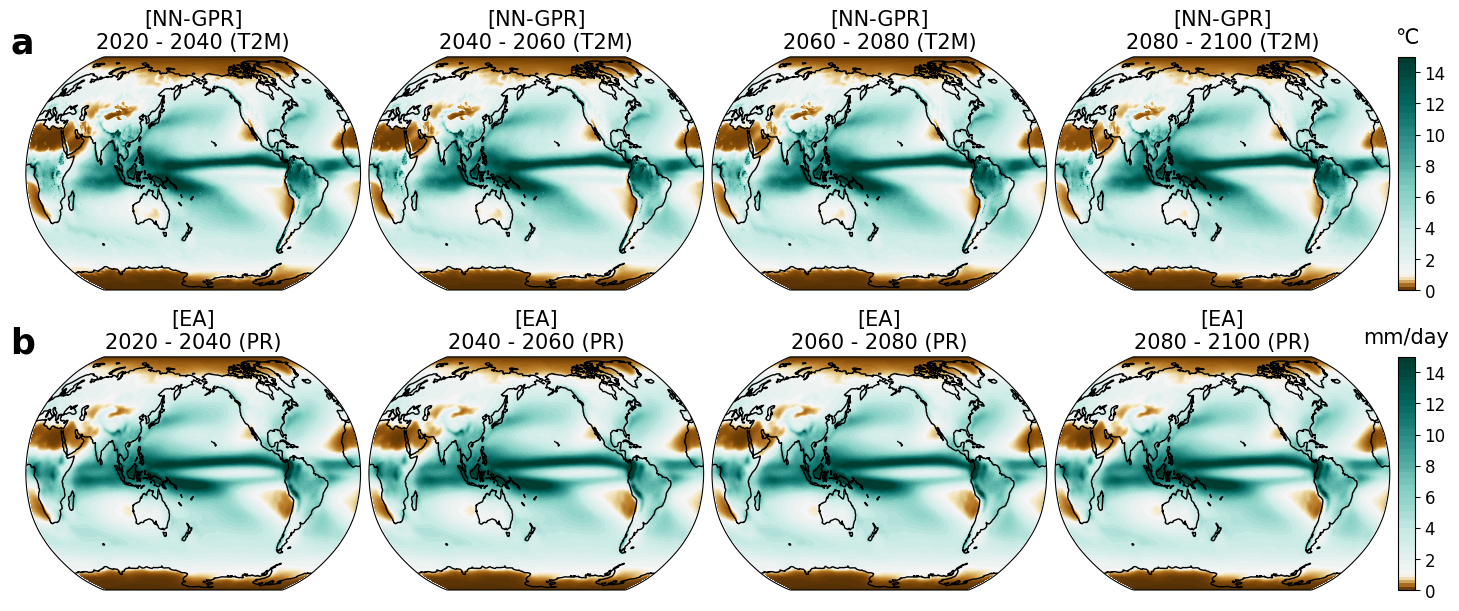

In [23]:
data_crs = ccrs.PlateCarree(central_longitude=180)
plot_crs = ccrs.Robinson(central_longitude=180)

fig = plt.figure(constrained_layout = True, figsize = (15, 6))
gs = GridSpec(2, 5, width_ratios = [1, 1, 1, 1, 0.05], figure = fig)

# ax = plt.subplot(gs[0, 0])
# ax.text(0.035, 0.45, 'a', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)

divnorm = colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=15)
cmap = plt.get_cmap('BrBG', 71)
for i in trange(4, leave = False):
    ax = plt.subplot(gs[i], projection=plot_crs)
    im = ax.imshow(nngp_pr[i], cmap = cmap, norm = divnorm, transform = data_crs)
    ax.coastlines()
    ax.set_aspect('auto', adjustable=None)
    ax.set_title(f'[NN-GPR]\n{2020 + 10*(2*i)} - {2020 + 10*(2*i+2)} (T2M)', fontsize = 15)
    
    if i == 0:
        ax.text(0.04, 0.92, 'a', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)
    
ax = plt.subplot(gs[0, 4])
cbar = plt.colorbar(im, cax=ax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('\u2103', fontsize = 15, pad = 10)
    
# divnorm = colors.TwoSlopeNorm(vmin=-6, vcenter=0, vmax=4)
# cmap = plt.get_cmap('BrBG', 31)
for j in trange(4, leave = False):
    ax = plt.subplot(gs[2 + i + j], projection=plot_crs)
    im = ax.imshow(ens_pr[i], cmap = cmap, norm = divnorm, transform = data_crs)
    ax.coastlines()
    ax.set_aspect('auto', adjustable=None)
    ax.set_title(f'[EA]\n{2020 + 10*(2*j)} - {2020 + 10*(2*j+2)} (PR)', fontsize = 15)
    
    if j == 0:
        ax.text(0.04, 0.42, 'b', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)
    
ax = plt.subplot(gs[1, 4])
cbar = plt.colorbar(im, cax=ax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('mm/day', fontsize = 15, pad = 10)

# ax = plt.subplot(gs[1, 0])
# ax.text(0.04, 0.45, 'c', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)

plt.show()

In [10]:
### TAS
nngp = np.load('./tas_predictions/nngp_pred.npy', mmap_mode = 'r')
ens = np.load('./tas_predictions/lm_pred.npy', mmap_mode = 'r')[nval:]

nngp_yr = np.array([np.mean(nngp[(i*12):((i+1)*12)] * scale[None,:,None], axis = 0) for i in range(85)])
ens_yr = np.array([np.mean(ens[(i*12):((i+1)*12)] * scale[None,:,None], axis = 0) for i in range(85)])

nngp_dec = np.array([np.mean(nngp_yr[(i*10):((i+1)*10)], axis = 0) for i in range(9)])
nngp_dec = nngp_dec[0:8]
nngp_tas = np.array([x - nngp_dec[0] for x in nngp_dec])

ens_dec = np.array([np.mean(ens_yr[(i*10):((i+1)*10)], axis = 0) for i in range(9)])
ens_dec = ens_dec[0:8]
ens_tas = np.array([x - ens_dec[0] for x in ens_dec])


### PR
nngp = np.load('./pr_predictions/nngp_pred.npy', mmap_mode = 'r')
ens = np.load('./pr_predictions/lm_pred.npy', mmap_mode = 'r')[nval:]

nngp_yr = np.array([np.mean(nngp[(i*12):((i+1)*12)] * scale[None,:,None], axis = 0) for i in range(85)])
ens_yr = np.array([np.mean(ens[(i*12):((i+1)*12)] * scale[None,:,None], axis = 0) for i in range(85)])

nngp_dec = np.array([np.mean(nngp_yr[(i*10):((i+1)*10)], axis = 0) for i in range(9)])
nngp_dec = nngp_dec[0:8]
nngp_pr = np.array([x - nngp_dec[0] for x in nngp_dec])

ens_dec = np.array([np.mean(ens_yr[(i*10):((i+1)*10)], axis = 0) for i in range(9)])
ens_dec = ens_dec[0:8]
ens_pr = np.array([x - ens_dec[0] for x in ens_dec])

In [13]:
## North America
y1 = 160
y2 = y1 + 60
x1 = 940
x2 = x1 + 90

tas_win = tas[:,y1:y2,x1:x2]
nngp_win = tas_nngp[:,y1:y2,x1:x2]
lm_win = tas_lm[:,y1:y2,x1:x2]
ens_win = tas_ens[:,y1:y2,x1:x2]

s = 40

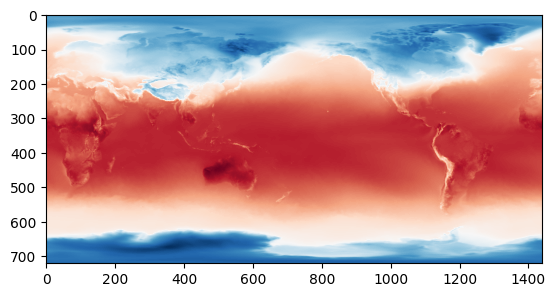

In [14]:
plt.imshow(tas[s], cmap = 'RdBu_r')

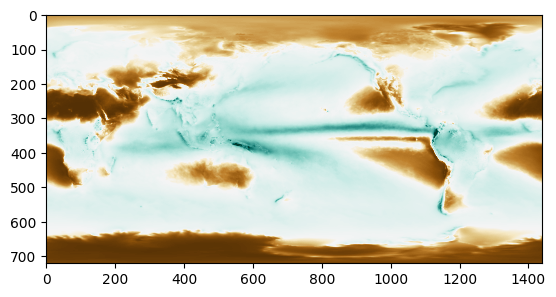

In [15]:
divnorm = colors.TwoSlopeNorm(vmin=0, vcenter=1.5, vmax=20)
plt.imshow(np.mean(pr, axis = 0), cmap = 'BrBG', norm = divnorm)

  0%|          | 0/3 [00:00<?, ?it/s]

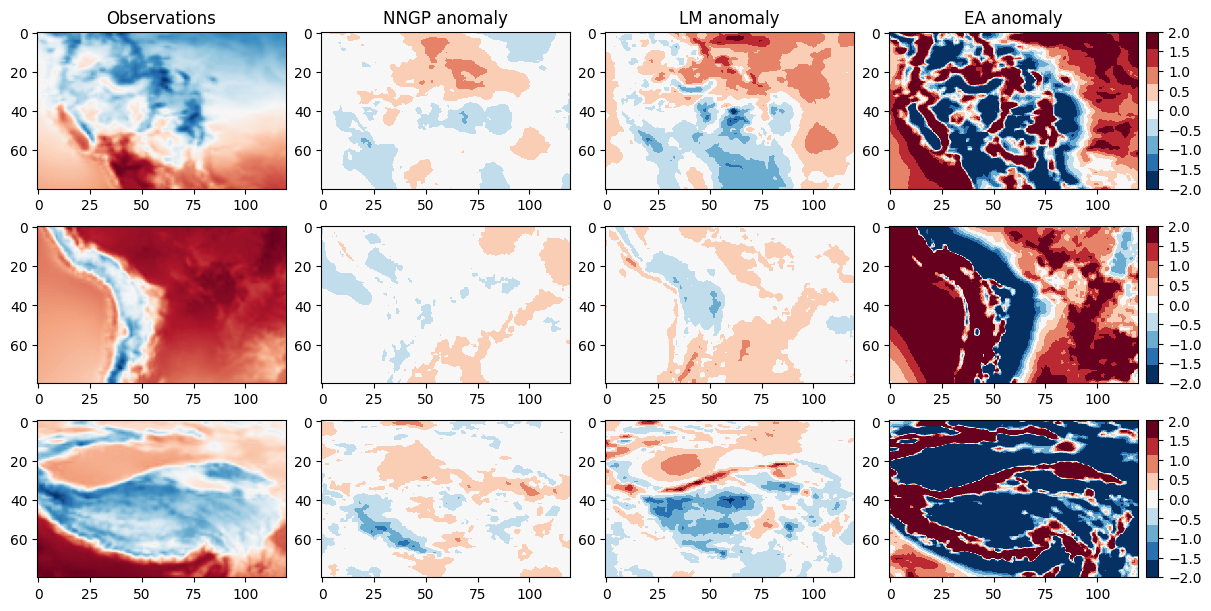

In [27]:
fig = plt.figure(constrained_layout = True, figsize = (12, 6))
gs = GridSpec(3, 5, width_ratios = [1, 1, 1, 1, 0.05], figure = fig)

titles = ['Observations', 'NNGP anomaly', 'LM anomaly', 'EA anomaly']
coords = [[160, 940], [400, 1125], [180, 300]]
divnorm = colors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2)
cmap = plt.get_cmap('RdBu_r', 9)

for k in trange(3, leave = False):
    y1 = coords[k][0]
    y2 = y1 + 80
    x1 = coords[k][1]
    x2 = x1 + 120
    
    data = [np.mean(tas[:,y1:y2,x1:x2], axis = 0),
        np.mean(tas_nngp[:,y1:y2,x1:x2], axis = 0),
        np.mean(tas_lm[:,y1:y2,x1:x2], axis = 0),
        np.mean(tas_ens[:,y1:y2,x1:x2], axis = 0)]
    
    ax = plt.subplot(gs[k, 0])
    ax.imshow(data[0], cmap = 'RdBu_r', aspect='auto')
    if k == 0:
        ax.set_title(titles[0])
    
    for p in range(1, 4):
        ax = plt.subplot(gs[k, p])
        im = ax.imshow(data[p] - data[0], cmap = cmap, aspect='auto', norm = divnorm)
        if k == 0:
            ax.set_title(titles[p])
        
    ax = plt.subplot(gs[k, 4])
    cbar = plt.colorbar(im, cax=ax)
    cbar.ax.tick_params(labelsize=10)

  0%|          | 0/3 [00:00<?, ?it/s]

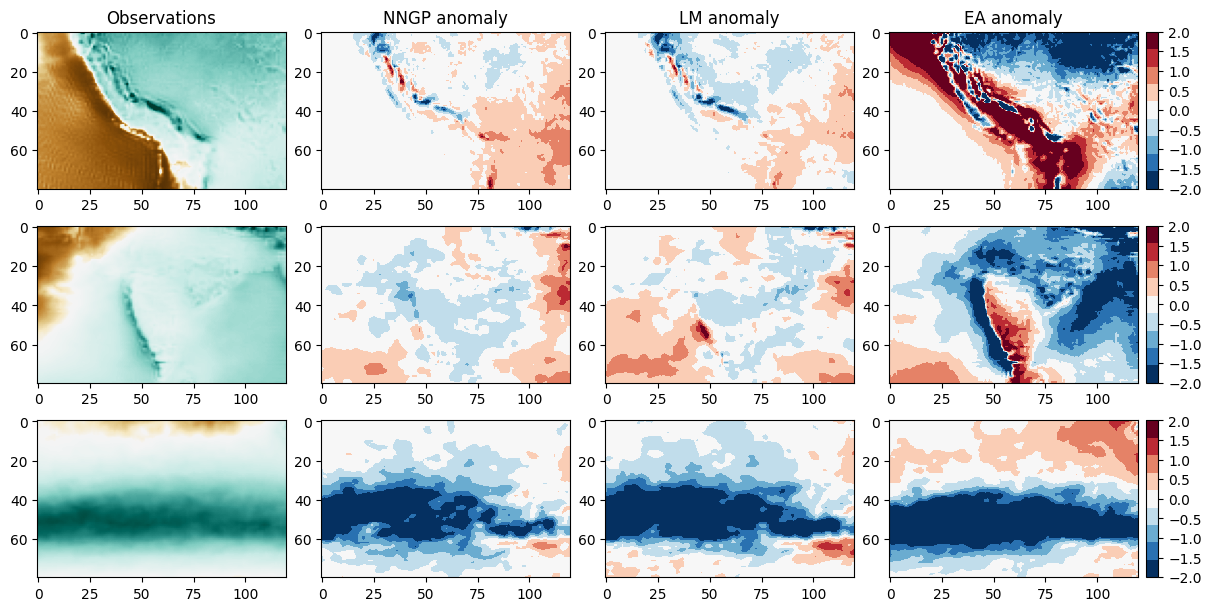

In [34]:
fig = plt.figure(constrained_layout = True, figsize = (12, 6))
gs = GridSpec(3, 5, width_ratios = [1, 1, 1, 1, 0.05], figure = fig)

titles = ['Observations', 'NNGP anomaly', 'LM anomaly', 'EA anomaly']
coords = [[375, 1100], [250, 250], [275, 900]]
divnorm = colors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2)
obs_divnorm = colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=15)
cmap = plt.get_cmap('RdBu_r', 9)

for k in trange(3, leave = False):
    y1 = coords[k][0]
    y2 = y1 + 80
    x1 = coords[k][1]
    x2 = x1 + 120
    
    data = [np.mean(pr[:,y1:y2,x1:x2], axis = 0),
        np.mean(pr_nngp[:,y1:y2,x1:x2], axis = 0),
        np.mean(pr_lm[:,y1:y2,x1:x2], axis = 0),
        np.mean(pr_ens[:,y1:y2,x1:x2], axis = 0)]
    
    ax = plt.subplot(gs[k, 0])
    ax.imshow(data[0], cmap = 'BrBG', aspect='auto', norm = obs_divnorm)
    if k == 0:
        ax.set_title(titles[0])
    
    for p in range(1, 4):
        ax = plt.subplot(gs[k, p])
        im = ax.imshow(data[p] - data[0], cmap = cmap, aspect='auto', norm = divnorm)
        if k == 0:
            ax.set_title(titles[p])
        
    ax = plt.subplot(gs[k, 4])
    cbar = plt.colorbar(im, cax=ax)
    cbar.ax.tick_params(labelsize=10)

In [ ]:
### statistics

In [26]:
### load predictions
nngp = np.load('./tas_predictions/nngp_pred.npy', mmap_mode = 'r')[0:pred_int]
lm = np.load('./tas_predictions/lm_pred.npy', mmap_mode = 'r')[nval:(nval + pred_int)]
ens = np.load('./tas_predictions/ens_pred.npy', mmap_mode = 'r')[nval:(nval + pred_int)]
obs = np.load('../data/saved/t2m_obs.npy', mmap_mode = 'r')[nfit:(nfit + pred_int)]

nngp = np.load('./pr_predictions/nngp_pred.npy', mmap_mode = 'r')[0:pred_int]
lm = np.load('./pr_predictions/lm_pred.npy', mmap_mode = 'r')[nval:(nval + pred_int)]
ens = np.load('./pr_predictions/ens_pred.npy', mmap_mode = 'r')[nval:(nval + pred_int)]
obs = np.load('../data/saved/pr_obs.npz.npy', mmap_mode = 'r')[nfit:(nfit + pred_int)]


nngp = np.array(nngp)
lm = np.array(lm)
ens = np.array(ens)
obs = np.array(obs)

### load observations and center
scale = np.cos(np.linspace(math.pi/2, -math.pi/2, 721))
scale /= np.mean(scale)
scale = scale[None,:,None]

In [17]:
nngp_mb = np.mean((nngp - obs) * scale, axis = (1, 2))
lm_mb = np.mean((lm - obs) * scale, axis = (1, 2))
ens_mb = np.mean((ens - obs) * scale, axis = (1, 2))

In [18]:
print(np.mean(nngp_mb))
print(np.mean(lm_mb))
print(np.mean(ens_mb))

-0.0035164545202562643
-0.10600325885753117
0.04382824589368141


In [19]:
nngp_mb = np.max(nngp - obs, axis = (1, 2))
lm_mb = np.max(lm - obs, axis = (1, 2))
ens_mb = np.max(ens - obs, axis = (1, 2))

In [20]:
print(np.mean(nngp_mb))
print(np.mean(lm_mb))
print(np.mean(ens_mb))

25.245913731378717
27.2242919418503
14.928518811633158


In [21]:
nngp_mb = np.std((nngp - obs) * scale, axis = (1, 2))
lm_mb = np.std((lm - obs) * scale, axis = (1, 2))
ens_mb = np.std((ens - obs) * scale, axis = (1, 2))

In [22]:
print(np.mean(nngp_mb))
print(np.mean(lm_mb))
print(np.mean(ens_mb))

2.2677083971683643
2.4044977791433406
2.7459857592481445


In [45]:
## North America
y1 = 160
y2 = y1 + 60
x1 = 940
x2 = x1 + 90

# ## LM is noisy
# y1 = 300
# y2 = y1 + 60
# x1 = 500
# x2 = x1 + 90

# ## test
# y1 = 130
# y2 = y1 + 60
# x1 = 0
# x2 = x1 + 90

ytest_win = ytest[:,y1:y2,x1:x2]
nngp_win = nngp[:,y1:y2,x1:x2]
lm_win = lm[:,y1:y2,x1:x2]
ens_win = ens[:,y1:y2,x1:x2]

In [110]:
fig, ax = plt.subplots(2, 2, constrained_layout = True, figsize = (10, 7))
ax = ax.reshape(-1)

ax[0].imshow(ytest_win[0], cmap = 'RdBu_r')
ax[1].imshow(nngp_win[0], cmap = 'RdBu_r')
ax[2].imshow(lm_win[0], cmap = 'RdBu_r')
ax[3].imshow(ens_win[0], cmap = 'RdBu_r')

In [84]:
### mse
metric_mse = [np.mean((nngp_win - ytest_win)**2 * scale[None,y1:y2,None], axis = (1, 2)),
              np.mean((lm_win - ytest_win)**2 * scale[None,y1:y2,None], axis = (1, 2)),
              np.mean((ens_win - ytest_win)**2 * scale[None,y1:y2,None], axis = (1, 2))]

### ssim
metric_ssim = [np.array([ssim(ytest_win[i].astype('float32'), nngp_win[i].astype('float32')) for i in trange(pred_int)]),
               np.array([ssim(ytest_win[i].astype('float32'), lm_win[i].astype('float32')) for i in trange(pred_int)]),
               np.array([ssim(ytest_win[i].astype('float32'), ens_win[i].astype('float32')) for i in trange(pred_int)])]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

In [85]:
metrics = [metric_mse, metric_ssim]

In [111]:
fig = plt.figure(constrained_layout = True, figsize = (12, 4))
gs = GridSpec(1, 2, figure = fig)

####### boxplots
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

# color the plots
plt_colors = ['C1', '#1f77b499', '#1f77b450']

titles = ['MSE', 'SSIM', 'CRPS', 'Coverage']
models = ['NN-GPR', 'LM', 'EA']

ax = plt.subplot(gs[0, 0])
ax.text(0.035, 0.932, 'a', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)

for i, metric in enumerate(metrics):
    ax = plt.subplot(gs[0, i])
    bp = ax.boxplot(metric, patch_artist=True, labels=models)
    ax.tick_params(axis='both', which='major', labelsize = 15)
    ax.set_title(titles[i], fontsize = 20)

    set_box_color(bp, 'black')
    bp['boxes'][0].set_facecolor(plt_colors[0])
    bp['boxes'][1].set_facecolor(plt_colors[1])
    bp['boxes'][2].set_facecolor(plt_colors[2])

In [20]:
### mse
metric_mse = [np.mean((sgpr - ytest)**2 * scale[None,:,None], axis = (1, 2)),
              np.mean((ylm - ytest)**2 * scale[None,:,None], axis = (1, 2)),
              np.mean((ens_mean - ytest)**2 * scale[None,:,None], axis = (1, 2))]

### ssim
metric_ssim = [np.array([ssim(ytest[i].astype('float32'), sgpr[i].astype('float32')) for i in trange(pred_int)]),
               np.array([ssim(ytest[i].astype('float32'), ylm[i].astype('float32')) for i in trange(pred_int)]),
               np.array([ssim(ytest[i].astype('float32'), ens_mean[i].astype('float32')) for i in trange(pred_int)])]


### crps
# metric_crps = [np.mean(ps.crps_gaussian(ytest, sgpr, sgpr_sig[:,None,None]) * scale[None,:,None], axis = (1, 2)),
#                np.mean(ps.crps_gaussian(ytest, ylm, ens_sd) * scale[None,:,None], axis = (1, 2)),
#                np.mean(ps.crps_gaussian(ytest, ens_mean, ens_sd) * scale[None,:,None], axis = (1, 2))]

### cover
sgpr_lb = sgpr - 1.96 * sgpr_sig[:,None,None]
sgpr_ub = sgpr + 1.96 * sgpr_sig[:,None,None]
sgpr_oob = (ytest > sgpr_ub) + (ytest < sgpr_lb)
sgpr_oob = sgpr_oob * scale[None,:,None]
sgpr_cov = 1-np.mean(sgpr_oob, axis = (1, 2))
                        
lm_lb = ylm - 1.96 * ens_sd
lm_ub = ylm + 1.96 * ens_sd
lm_oob = (ytest > lm_ub) + (ytest < lm_lb)
lm_oob = lm_oob * scale[None,:,None]
lm_cov = 1-np.mean(lm_oob, axis = (1, 2))

ens_lb = ens_mean - 1.96 * ens_sd
ens_ub = ens_mean + 1.96 * ens_sd
ens_oob = (ytest > ens_ub) + (ytest < ens_lb)
ens_oob = ens_oob * scale[None,:,None]
ens_cov = 1-np.mean(ens_oob, axis = (1, 2))

metrics_cover = [sgpr_cov, lm_cov, ens_cov]

metrics = [metric_mse, metric_ssim, metric_crps, metrics_cover]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

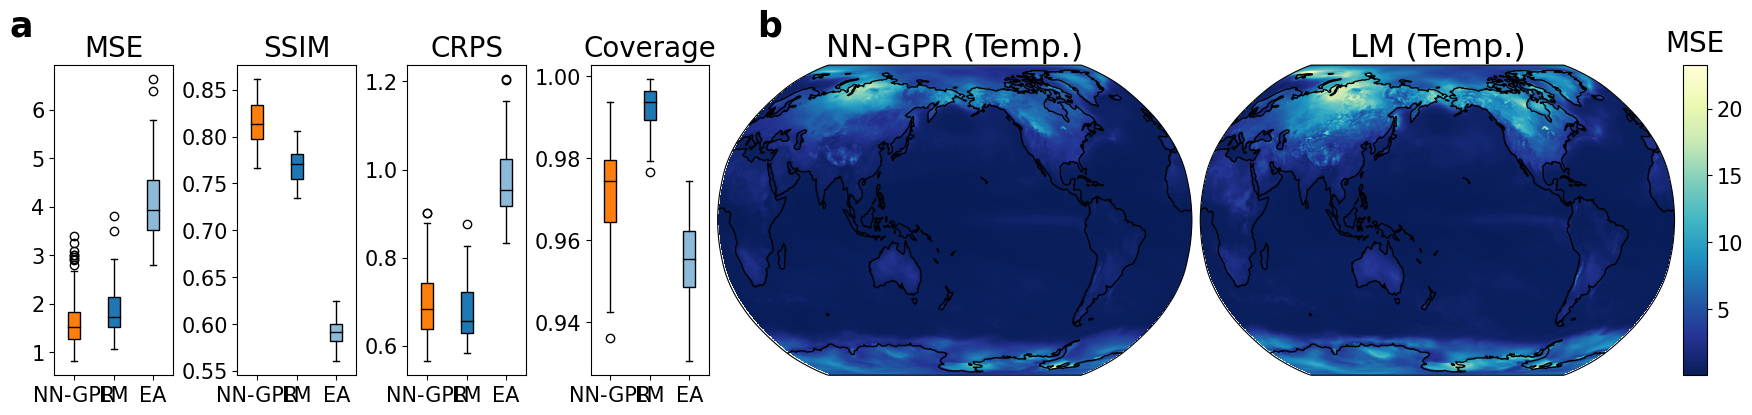

In [25]:
fig = plt.figure(constrained_layout = True, figsize = (18, 4))
gs = GridSpec(1, 7, width_ratios = [0.25, 0.25, 0.25, 0.25, 1, 1, 0.05], figure = fig)
data_crs = ccrs.PlateCarree(central_longitude=180)
plot_crs = ccrs.Robinson(central_longitude=180)


####### boxplots
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

# color the plots
plt_colors = ['C1', 'C0', '#1f77b480']


titles = ['MSE', 'SSIM', 'CRPS', 'Coverage']
models = ['NN-GPR', 'LM', 'EA']

ax = plt.subplot(gs[0, 0])
ax.text(0.035, 0.932, 'a', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)

for i, metric in enumerate(metrics):
    ax = plt.subplot(gs[0, i])
    bp = ax.boxplot(metric, patch_artist=True, labels=models)
    ax.tick_params(axis='both', which='major', labelsize = 15)
    ax.set_title(titles[i], fontsize = 20)

    set_box_color(bp, 'black')
    bp['boxes'][0].set_facecolor(plt_colors[0])
    bp['boxes'][1].set_facecolor(plt_colors[1])
    bp['boxes'][2].set_facecolor(plt_colors[2])


####### MSE maps
divnorm = colors.TwoSlopeNorm(vmin=0, vcenter=2, vmax=20)
error_maps = [np.mean((sgpr - ytest)**2, axis = 0),
              np.mean((ylm  - ytest)**2, axis = 0),
              np.mean((ens_mean  - ytest)**2, axis = 0)]
titles = ['NN-GPR (Temp.)', 'LM (Temp.)', 'EA (Temp.)']


# divnorm=colors.TwoSlopeNorm(vmin=0, vcenter=10, vmax=20)

ax = plt.subplot(gs[0, 4], projection=plot_crs)
ax.text(0.45, 0.932, 'b', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)

for k in range(2):
    ax = plt.subplot(gs[0,k + 4], projection=plot_crs)
    ax.set_title(titles[k], fontsize = 23)
    im = ax.imshow(error_maps[k],
          cmap = 'YlGnBu_r', 
          origin='upper', 
          transform = data_crs)
    ax.coastlines()
    ax.set_aspect('auto', adjustable=None)
    
ax = plt.subplot(gs[0, 6])
cbar = plt.colorbar(im, cax=ax)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_title('MSE', fontsize = 20, pad = 10)
plt.show()

In [112]:
fig = plt.figure(constrained_layout = True, figsize = (16, 8))
gs = GridSpec(2, 4, width_ratios = [1, 1, 1, 0.05], figure = fig)
data_crs = ccrs.PlateCarree(central_longitude=180)
plot_crs = ccrs.Robinson(central_longitude=180)



####### average reanalysis field
divnorm = colors.TwoSlopeNorm(vmin=-70, vcenter=0, vmax=40)

ax = plt.subplot(gs[0,0], projection=plot_crs)
ax.set_title('Reanalysis mean', fontsize = 23)
im = ax.imshow(np.mean(ytest, axis = 0), 
      cmap = 'RdBu_r', 
      origin='upper', 
      transform = data_crs,
      norm = divnorm)
ax.coastlines()
ax.set_aspect('auto', adjustable=None)


ax.text(0.035, 0.932, 'a', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)


####### average predictions
titles = ['NN-GPR mean', 'EA mean']
pred_maps = [np.mean(sgpr, axis = 0), np.mean(ylm, axis = 0)]

for k in range(2):
    ax = plt.subplot(gs[0, k+1], projection=plot_crs)
    ax.set_title(titles[k], fontsize = 23)
    im = ax.imshow(pred_maps[k] - np.mean(ytest, axis = 0),
          cmap = 'RdBu_r', 
          origin='upper', 
          transform = data_crs)
    ax.coastlines()
    ax.set_aspect('auto', adjustable=None)
    
ax = plt.subplot(gs[0, 3])
cbar = plt.colorbar(im, cax=ax)
cbar.ax.tick_params(labelsize=15)

tick_locator = ticker.MaxNLocator(nbins = 7)
cbar.locator = tick_locator
cbar.update_ticks()

cbar.ax.set_title('Temp. (C)', fontsize = 20, pad = 10)
# cbar.set_label('C', fontsize = 15)

####### average reanalysis field
divnorm = colors.TwoSlopeNorm(vmin=-15, vcenter=0, vmax=30)

ax = plt.subplot(gs[1,0], projection=plot_crs)
ax.set_extent([70, 100, 27, 42])
ax.set_title('Reanalysis mean\n(Tibetan Plateau)', fontsize = 23)
im = ax.imshow(np.mean(ytest, axis = 0), 
      cmap = 'RdBu_r', 
      origin='upper', 
      transform = data_crs)
ax.add_feature(cfeature.BORDERS)
# ax.set_aspect('auto', adjustable=None)


####### average predictions
titles = ['NN-GPR mean\n(Tibetan Plateau)', 'EA mean\n(Tibetan Plateau)']
pred_maps = [np.mean(sgpr, axis = 0), np.mean(ylm, axis = 0)]

for k in range(2):
    ax = plt.subplot(gs[1, k+1], projection=plot_crs)
    ax.set_extent([70, 100, 27, 42])
    ax.set_title(titles[k], fontsize = 23)
    im = ax.imshow(pred_maps[k] - np.mean(ytest, axis = 0),
          cmap = 'RdBu_r', 
          origin='upper', 
          transform = data_crs)
    ax.add_feature(cfeature.BORDERS)
#     ax.set_aspect('auto', adjustable=None)
    
ax = plt.subplot(gs[1, 3])
cbar = plt.colorbar(im, cax=ax)
cbar.ax.tick_params(labelsize=15)

tick_locator = ticker.MaxNLocator(nbins = 7)
cbar.locator = tick_locator
cbar.update_ticks()

# cbar.ax.set_title('Precip.', fontsize = 20, pad = 10)
# cbar.set_label('C', fontsize = 15)

plt.show()

In [9]:
ytrain2 = reanalysis[0:nfit]
scale = np.cos(np.linspace(math.pi/2, -math.pi/2, ytrain2.shape[1]))
scale /= np.mean(scale)
ymean = jnp.mean(ytrain2 * scale[None,:,None])

In [10]:
scale = np.cos(np.linspace(math.pi/2, -math.pi/2, nlat))
scale /= np.mean(scale)

sgpr = []
for i in trange(6):
    sgpr0, _ = nngp_dist(params, xtest[(i * 200):((i+1)*200)], xtrain, ytrain)
    sgpr0 += (x[(i * 200):((i+1)*200)] @ beta)[:,None]
    sgpr0 = sgpr0.reshape((-1, nlat, nlon))

    sgpr.append(np.mean(sgpr0*scale[None,:,None], axis = (1, 2)))
    
sgpr = np.concatenate(sgpr)
sgpr_yr = np.array([np.mean(sgpr[(i*12):((i+1)*12)]) for i in range(85)])  - ymean

  0%|          | 0/6 [00:00<?, ?it/s]

NameError: name 'params' is not defined

In [16]:
xtest = []
for m in range(nmod):
    xt = xrcp[m][nval:]
    scale = np.cos(np.linspace(math.pi/2, -math.pi/2, xt.shape[1]))
    scale /= np.mean(scale)
    xt = np.mean(xt * scale[None,:,None], axis = (1, 2))
    xt_yr = np.array([np.mean(xt[(i*12):((i+1)*12)]) for i in range(85)])
    
    xtest.append(xt_yr - ymean)

In [ ]:
#### construct training set
pred_int = 70

ylm = []
for k in trange(85):
    for i in trange(nmod, leave = False):

        x = xrcp[i][(k*12):((k+1)*12)]
        x = np.moveaxis(x, 0, 2)
        x = resize(x, (nlat, nlon))
        x = np.moveaxis(x, 2, 0)

        beta_i = beta[:,:,i,0]
        ylm.append(x * beta_i[None,:,:])

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
ylm = np.concatenate(ylm)
ylm_yr = np.array([np.mean(ylm[(i*12):((i+1)*12)]) for i in range(85)])  - ymean

In [ ]:
pred_int = 70

ytest2 = reanalysis[nfit:(nfit + pred_int),]
scale = np.cos(np.linspace(math.pi/2, -math.pi/2, ytest2.shape[1]))
scale /= np.mean(scale)
ytest2 = np.mean(ytest2 * scale[None,:,None], axis = (1, 2))

In [ ]:
obs = np.array([np.mean(ytest2[(i*12):((i+1)*12)]) for i in range(6)])  - ymean

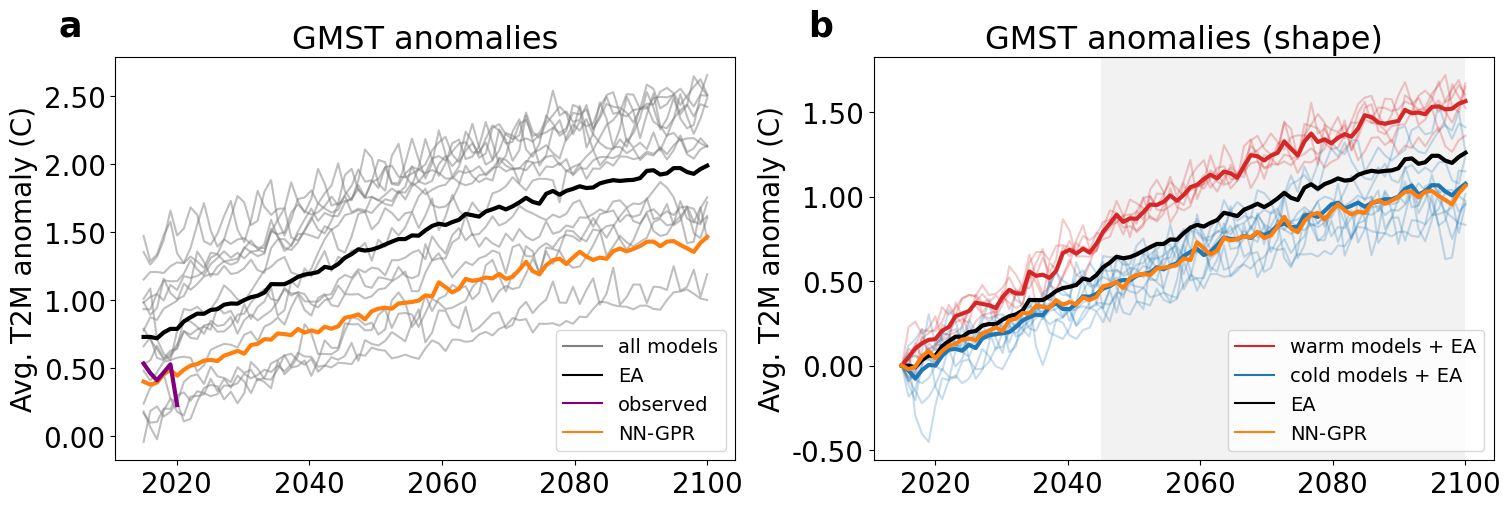

In [22]:
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (15, 5))


plt.rc('ytick', labelsize = 20)
plt.rc('xtick', labelsize = 20)


s = np.linspace(2015, 2100, 85)

cold_avg0 = 0
cold_avg1 = 0
warm_avg0 = 0
warm_avg1 = 0
ens_avg = 0

### plotting
n = 0
m = 0
for xt in xtest:
    if (xt - xt[0])[37] > 0.7:
        ax[0].plot(s, xt, c = 'grey', alpha = 0.5)
        ax[1].plot(s, xt - xt[0], c = 'C3', alpha = 0.25)
        
        m = m + 1
        warm_avg0 += xt
        warm_avg1 += xt - xt[0]
    else:
        n = n + 1
        cold_avg0 += xt
        cold_avg1 += xt - xt[0]
        
        ax[0].plot(s, xt, c = 'grey', alpha = 0.5)
        ax[1].plot(s, xt - xt[0], c = 'C0', alpha = 0.25)
        
ax[0].plot(s, np.mean(np.array([x for x in xtest]), axis = 0), c = 'black', linewidth = 3)
ax[0].plot(s, sgpr_yr, c = 'C1', linewidth = 3)
ax[0].plot(s[0:6], obs, c = 'purple', linewidth = 3)
ax[0].set_title('GMST anomalies', fontsize = 23)

ax[1].plot(s, np.mean(np.array([x - x[0] for x in xtest]), axis = 0), c = 'black', linewidth = 3)
ax[1].plot(s, warm_avg1/m, c = 'C3', linewidth = 3)
ax[1].plot(s, cold_avg1/n, c = 'C0', linewidth = 3)
ax[1].plot(s, sgpr_yr - sgpr_yr[0], c = 'C1', linewidth = 3)
ax[1].set_title('GMST anomalies (shape)', fontsize = 23)
ax[1].axvspan(2045, 2100, facecolor='grey', alpha=0.10)


### legend
ax[0].plot([],[], c='grey', label = 'all models')
ax[0].plot([],[], c='black', label = 'EA')
ax[0].plot([],[], c='purple', label = 'observed')
ax[0].plot([],[], c='C1', label = 'NN-GPR')
ax[0].legend(fontsize = 14, loc = 'lower right')

ax[1].plot([],[], c='C3', label = 'warm models + EA')
ax[1].plot([],[], c='C0', label = 'cold models + EA')
ax[1].plot([],[], c='black', label = 'EA')
ax[1].plot([],[], c='C1', label = 'NN-GPR')
ax[1].legend(fontsize = 14, loc = 'lower right')


### labels
custom_ticks = np.linspace(2020, 2100, 5, dtype=int)
ax[0].set_xticks(custom_ticks)
ax[0].set_xticklabels(custom_ticks)
ax[0].set_ylabel('Avg. T2M anomaly (C)', fontsize = 20)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax[1].set_xticks(custom_ticks)
ax[1].set_xticklabels(custom_ticks)
ax[1].set_ylabel('Avg. T2M anomaly (C)', fontsize = 20)
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


ax[0].text(0.035, 0.932, 'a', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)
ax[1].text(0.535, 0.932, 'b', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)
   
plt.show()